# Pass clustering to see how teams penetrate into final third

In [81]:
import duckdb

import mplsoccer
from mplsoccer import Pitch, VerticalPitch

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

## Nalaganje Podatkov

In [82]:
df_stories = duckdb.sql(f"""
    SELECT * FROM 'data/stories.parquet'
    WHERE type = 'pass'
""").df()

df_stories.head(3)

player_position  throw_in  start_x  penalty_conceded_goal  penalty_foul  \
0             AMF     False       49                  False         False   
1              CF     False       27                  False         False   
2             RCB     False       57                  False         False   

   lateral_pass  own_goal  linkup_play  type  red_card  ...  shot_goal_zone  \
0         False     False        False  pass     False  ...            None   
1         False     False        False  pass     False  ...            None   
2         False     False        False  pass     False  ...            None   

   conceded_goal  is_pass  possession_attack  pass_blocked  opportunity  \
0          False     True               True         False        False   
1          False     True               True         False        False   
2          False     True               True         False        False   

   possession_id  shot_id  possession_set_piece_attack  __index_level_0__  
0     1296149340        0                        False                  0  
1     1296149340        0                        False                  1  
2     1296149340        0                        False                  3  

[3 rows x 138 columns]

In [83]:
df_stories_filtered = df_stories[df_stories['pass_to_final_third']]
df_stories_filtered.shape

(112931, 138)

In [84]:
# List of columns to check
columns_to_check = [
    'possession_free_kick', 'free_kick', 'free_kick_cross', 
    'possession_free_kick_cross', 'possession_direct_free_kick', 
    'possession_corner', 'corner', 'possession_set_piece_attack',
    'hand_pass'
]

# Filter out rows where any of the specified columns are True
df_stories_brez_prekinitev = df_stories_filtered[~df_stories_filtered[columns_to_check].any(axis=1)]

# Display the first few rows to verify
df_stories_brez_prekinitev.shape

(89765, 138)

In [85]:
# List of columns to keep
columns_to_keep = [
    'id',
    'start_x', 
    'start_y', 
    'end_x', 
    'end_y', 
    'pass_length',
    'successful',
    'pass_high',
    'player_id',
    'team_id',
    'pass_recipient_id',
    'player_position',
    'season',
    'long_pass',
    'possession_id',
    'minute'
]

# Select only the desired columns
df_done = df_stories_brez_prekinitev[columns_to_keep]

# Display the first few rows to verify
df_done.head()

id  start_x  start_y  end_x  end_y  pass_length  successful  \
2   1296149344       57       80     67     92           13        True   
27  1296149381       64       82     74     74           12        True   
34  1296149390       59       71     68     88           15        True   
38  1296149394       61       64     67     92           20        True   
48  1296149410       56       74     67     75           12        True   

    pass_high  player_id  team_id  pass_recipient_id player_position  season  \
2       False     370224     1609             302292             RCB    2021   
27      False     120339     1609             302292            RDMF    2021   
34      False     370224     1609              70389             RCB    2021   
38      False     120339     1609              70389            RDMF    2021   
48      False      70389     1609             346158              RB    2021   

    long_pass  possession_id  minute  
2       False     1296149340       0  
27      False     1296149379       2  
34      False     1296149379       2  
38      False     1296149379       2  
48      False     1296149405       3

In [86]:
# Create a copy and scale the coordinates to real pitch dimensions (105x68 meters)
df_done_copy = df_done.copy()
df_done_copy["start_x"] *= 105 / 100
df_done_copy["start_y"] *= 68 / 100
df_done_copy["end_x"] *= 105 / 100
df_done_copy["end_y"] *= 68 / 100

df_done_copy.head(3)

id  start_x  start_y  end_x  end_y  pass_length  successful  \
2   1296149344    59.85    54.40  70.35  62.56           13        True   
27  1296149381    67.20    55.76  77.70  50.32           12        True   
34  1296149390    61.95    48.28  71.40  59.84           15        True   

    pass_high  player_id  team_id  pass_recipient_id player_position  season  \
2       False     370224     1609             302292             RCB    2021   
27      False     120339     1609             302292            RDMF    2021   
34      False     370224     1609              70389             RCB    2021   

    long_pass  possession_id  minute  
2       False     1296149340       0  
27      False     1296149379       2  
34      False     1296149379       2

In [87]:
# Recalculate pass_length using scaled coordinates
df_done_copy["pass_length"] = np.sqrt(
    (df_done_copy["end_x"] - df_done_copy["start_x"])**2 +
    (df_done_copy["end_y"] - df_done_copy["start_y"])**2
)

df_done_copy.head(3)

id  start_x  start_y  end_x  end_y  pass_length  successful  \
2   1296149344    59.85    54.40  70.35  62.56    13.297955        True   
27  1296149381    67.20    55.76  77.70  50.32    11.825549        True   
34  1296149390    61.95    48.28  71.40  59.84    14.931045        True   

    pass_high  player_id  team_id  pass_recipient_id player_position  season  \
2       False     370224     1609             302292             RCB    2021   
27      False     120339     1609             302292            RDMF    2021   
34      False     370224     1609              70389             RCB    2021   

    long_pass  possession_id  minute  
2       False     1296149340       0  
27      False     1296149379       2  
34      False     1296149379       2

In [88]:
df_done_copy["angle"] = np.arctan2(df_done_copy["end_y"] - df_done_copy["start_y"], df_done_copy["end_x"] - df_done_copy["start_x"])
df_done_copy.head(3)

id  start_x  start_y  end_x  end_y  pass_length  successful  \
2   1296149344    59.85    54.40  70.35  62.56    13.297955        True   
27  1296149381    67.20    55.76  77.70  50.32    11.825549        True   
34  1296149390    61.95    48.28  71.40  59.84    14.931045        True   

    pass_high  player_id  team_id  pass_recipient_id player_position  season  \
2       False     370224     1609             302292             RCB    2021   
27      False     120339     1609             302292            RDMF    2021   
34      False     370224     1609              70389             RCB    2021   

    long_pass  possession_id  minute     angle  
2       False     1296149340       0  0.660647  
27      False     1296149379       2 -0.478019  
34      False     1296149379       2  0.885491

In [89]:
# Randomly sample 75% of the DataFrame
df_smaller = df_done_copy.sample(frac=0.50, random_state=123)

# Optionally, reset the index if needed
df_smaller.reset_index(drop=True, inplace=True)

print(f"Original size: {len(df_done_copy)}, Reduced size: {len(df_smaller)}")

Original size: 89765, Reduced size: 44882


In [10]:
import pyarrow
import fastparquet
# Save the reduced DataFrame as Parquet
df_smaller.to_parquet('data/reduced_dataset.parquet', index=False)

print("DataFrame saved successfully!")

DataFrame saved successfully!


**Stara funkcija brez pass_high**

In [ ]:
# Perform clustering
k = 29  # Number of clusters determined by Gap Statistic
cluster = KMeans(n_clusters=k, random_state=2147)
labels = cluster.fit_predict(df_smaller[["start_x", "start_y", "end_x", "end_y", "angle"]].values)

# Add cluster labels to the dataframe
df_smaller["label"] = labels

# Set up the pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=5, nrows=6, grid_width=0.95, grid_height=0.9, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Maximum number of passes to display per cluster
max_passes = 50

# Plot each cluster on a separate pitch
for clust, ax in zip(range(k), axs['pitch'].flat[:k]):
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {clust + 1}",
            ha='center', va='center', fontsize=18)
    
    # Filter passes belonging to the current cluster
    clustered = df_done_copy[df_done_copy["label"] == clust]

    # Limit the number of passes displayed
    if len(clustered) > max_passes:
        clustered = clustered.sample(n=max_passes, random_state=2147)
    
    # Separate successful and unsuccessful passes
    successful = clustered[clustered["successful"]]
    unsuccessful = clustered[~clustered["successful"]]
    
    # Plot successful passes (green)
    pitch.arrows(
        successful["start_x"], successful["start_y"],
        successful["end_x"], successful["end_y"],
        color="green", ax=ax, width=1, label="Successful"
    )
    
    # Plot unsuccessful passes (red)
    pitch.arrows(
        unsuccessful["start_x"], unsuccessful["start_y"],
        unsuccessful["end_x"], unsuccessful["end_y"],
        color="red", ax=ax, width=1, label="Unsuccessful"
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Clusters of Passes', ha='center', va='center', fontsize=30)

# Save the plot to a file
plt.savefig("predstavitev/1_0/clusters_of_passes.png", dpi=300, bbox_inches="tight")
plt.show()

**Nova funkcija**

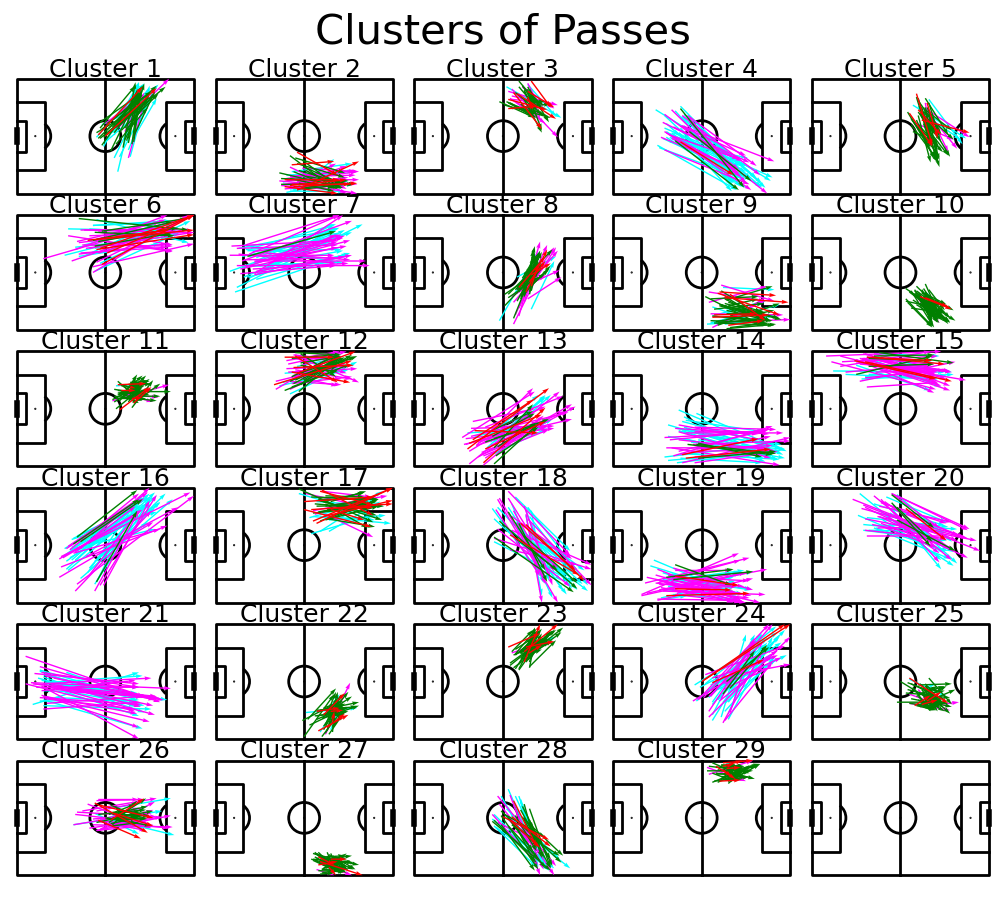

In [91]:
from sklearn.cluster import KMeans
# Perform clustering
k = 29  # Number of clusters determined by Gap Statistic
cluster = KMeans(n_clusters=k, random_state=2147)
labels = cluster.fit_predict(df_smaller[["start_x", "start_y", "end_x", "end_y", "angle"]].values)

# Add cluster labels to the dataframe
df_smaller["label"] = labels

# Set up the pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=5, nrows=6, grid_width=0.95, grid_height=0.9, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Maximum number of passes to display per cluster
max_passes = 50

# Plot each cluster on a separate pitch
for clust, ax in zip(range(k), axs['pitch'].flat[:k]):
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {clust + 1}",
            ha='center', va='center', fontsize=18)
    
    # Filter passes belonging to the current cluster
    clustered = df_smaller[df_smaller["label"] == clust]

    # Limit the number of passes displayed
    if len(clustered) > max_passes:
        clustered = clustered.sample(n=max_passes, random_state=2147)
    
    # Separate passes by success and pass_high
    successful_high = clustered[(clustered["successful"]) & (clustered["pass_high"])]
    unsuccessful_high = clustered[(~clustered["successful"]) & (clustered["pass_high"])]
    successful_low = clustered[(clustered["successful"]) & (~clustered["pass_high"])]
    unsuccessful_low = clustered[(~clustered["successful"]) & (~clustered["pass_high"])]

    # Plot successful high passes (cyan)
    pitch.arrows(
        successful_high["start_x"], successful_high["start_y"],
        successful_high["end_x"], successful_high["end_y"],
        color="cyan", ax=ax, width=1, label="Successful (High)"
    )
    
    # Plot unsuccessful high passes (magenta)
    pitch.arrows(
        unsuccessful_high["start_x"], unsuccessful_high["start_y"],
        unsuccessful_high["end_x"], unsuccessful_high["end_y"],
        color="magenta", ax=ax, width=1, label="Unsuccessful (High)"
    )
    
    # Plot successful low passes (green)
    pitch.arrows(
        successful_low["start_x"], successful_low["start_y"],
        successful_low["end_x"], successful_low["end_y"],
        color="green", ax=ax, width=1, label="Successful (Low)"
    )
    
    # Plot unsuccessful low passes (red)
    pitch.arrows(
        unsuccessful_low["start_x"], unsuccessful_low["start_y"],
        unsuccessful_low["end_x"], unsuccessful_low["end_y"],
        color="red", ax=ax, width=1, label="Unsuccessful (Low)"
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Clusters of Passes', ha='center', va='center', fontsize=30)
# Save the plot to a file
plt.savefig("predstavitev/1_0/clusters_of_passes.png", dpi=300, bbox_inches="tight")
plt.show()

### Poimenovanja clustrov od 1-29 na podlagi grafov in % visokih podaj
**Vse podaje se navezujejo na zadnjo tretino**
* medium primarily low pass from center to the high left of the attacking third
* medium mixed height pass down the right hand side from own half to the start of the attacking third
* short primarily low pass from the left of the middle third to half left of the attacking third
* long high pass from center or half left at the start of middle third to the right side of attacking third
* short to medium low pass from half left of the center third to center or half right of the attacking third
* long primarily high pass from left half of centre third to deep left of the attacking third
* long high pass from defending third to left half of the attacking third
* short to medium low pass from half right of the center third to center or half left of the attacking third
* medium primarily low pass from the end of right side middle third to deep right of the attacking third
* short low pass from half right of center to the high right of the attacking third
* 10
* short low pass from half left of center to the high half left of attacking third
* medium mixed height pass down the left hand side from own half to the start of the attacking third
* medium to long primarily high pass from right half of middle third to center of the attacking third
* long primarily high pass from right half of centre third to deep right of the attacking third
* medium to long high pass from left side of defending or middle third to high left side of attacking third
* long high pass from center or right half at the start of middle third to the left side of attacking third
* medium primarily low pass from the end of left side middle third to deep left of the attacking third
* long high pass from left half of the middle third to medium or deep right half of the attacking third
* medium to long high pass from right side of defending or middle third to high right side of attacking third
* medium to long primarily high pass from left half of middle third to center of the attacking third
* 20
* long high pass from defending third to right half of the attacking third
* short primarily low pass from the right of the middle third to half right of the attacking third
* short low pass from half left of center to the high left of the attacking third
* long high pass from right half of the middle third to medium or deep left half of the attacking third
* short low pass from half right of center to the high half right of attacking third
* medium mixed height pass from center throught the middle into the attacking third
* short low pass down the right hand side from middle to attacking third
* medium primarily low pass from center to the high right of the attacking third
* short low pass down the left hand side from middle to attacking third

### Nasprotni pari gruč
**Gre za gruče, ki so zrcaljene, npr. kratka nizka podaja v levo - kratka nizka podaja v desno:**
1-28, 2-12, 3-22, 4-16, 5-8, 6-14, 7-21, 9-17, 10-23, 11-25, 13-20, 15-19, 18-24, 27-29, (26) je sama; gre za podajo skozi sredino, ni možno zrcalit.

In [12]:
df_smaller.head()

id  start_x  start_y  end_x  end_y  pass_length  successful  \
0  2109521393    69.30     3.40  96.60   8.16    27.711867        True   
1  1812071042    17.85    61.20  72.45  63.24    54.638097        True   
2  1237652744    67.20    19.04  87.15   7.48    23.057235        True   
3  1134846854    13.65    59.16  70.35  54.40    56.899452        True   
4  2156457939    68.25    33.32  76.65  21.76    14.289633        True   

   pass_high  player_id  team_id  pass_recipient_id player_position  season  \
0      False     447205     1625             550459             LWF    2023   
1      False     551442     1624             472363              RB    2023   
2      False     344040     1651             247248            LCB3    2021   
3       True      11093     1644               9637             RCB    2021   
4      False      40756     1611             243588            RDMF    2023   

   long_pass  possession_id  minute     angle  label  
0      False     2109521364      82  0.172624      8  
1       True     1812071035      51  0.037345     14  
2      False     1237652729      75 -0.525171      8  
3       True     1134846853      74 -0.083754     14  
4      False     2156457929      52 -0.942412     24

In [15]:
df_smaller.to_csv("data/clustered_passes_HIGH_1.csv", index=False)

In [13]:
# Calculate percentage of high passes in each cluster
cluster_summary = (
    df_smaller.groupby("label")["pass_high"]
    .agg(["sum", "count"])  # Calculate total high passes and total passes
    .assign(percentage=lambda x: (x["sum"] / x["count"]) * 100)  # Calculate percentage
)

# Print the cluster summary
print(cluster_summary)

        sum  count  percentage
label                         
0       513   1471   34.874235
1       592   1395   42.437276
2       493   2090   23.588517
3      1122   1195   93.891213
4       288   1413   20.382166
5       594    759   78.260870
6       967    995   97.185930
7       385   1399   27.519657
8       427   1365   31.282051
9       160   2958    5.409060
10      262   2151   12.180381
11      822   1744   47.133028
12      664    833   79.711885
13      616    716   86.033520
14      794    911   87.156970
15     1011   1113   90.835580
16      540   1462   36.935705
17      990   1121   88.314005
18      812    931   87.218045
19      757    914   82.822757
20      861    868   99.193548
21      366   2108   17.362429
22      191   2950    6.474576
23      740    910   81.318681
24      264   1995   13.233083
25      440    954   46.121593
26      319   3407    9.363076
27      689   1587   43.415249
28      331   3167   10.451531


**Dictionary, ki vsebuje opis za vsak cluster label:**

In [10]:
cluster_descriptions = {
    0: "medium primarily low pass from center to the high left of the attacking third",
    1: "medium mixed height pass down the right hand side from own half to the start of the attacking third",
    2: "short primarily low pass from the left of the middle third to half left of the attacking third",
    3: "long high pass from center or half left at the start of middle third to the right side of attacking third",
    4: "short to medium low pass from half left of the center third to center or half right of the attacking third",
    5: "long primarily high pass from left half of centre third to deep left of the attacking third",
    6: "long high pass from defending third to left half of the attacking third",
    7: "short to medium low pass from half right of the center third to center or half left of the attacking third",
    8: "medium primarily low pass from the end of right side middle third to deep right of the attacking third",
    9: "short low pass from half right of center to the high right of the attacking third",
    10: "short low pass from half left of center to the high half left of attacking third",
    11: "medium mixed height pass down the left hand side from own half to the start of the attacking third",
    12: "medium to long primarily high pass from right half of middle third to center of the attacking third",
    13: "long primarily high pass from right half of centre third to deep right of the attacking third",
    14: "medium to long high pass from left side of defending or middle third to high left side of attacking third",
    15: "long high pass from center or right half at the start of middle third to the left side of attacking third",
    16: "medium primarily low pass from the end of left side middle third to deep left of the attacking third",
    17: "long high pass from left half of the middle third to medium or deep right half of the attacking third",
    18: "medium to long high pass from right side of defending or middle third to high right side of attacking third",
    19: "medium to long primarily high pass from left half of middle third to center of the attacking third",
    20: "long high pass from defending third to right half of the attacking third",
    21: "short primarily low pass from the right of the middle third to half right of the attacking third",
    22: "short low pass from half left of center to the high left of the attacking third",
    23: "long high pass from right half of the middle third to medium or deep left half of the attacking third",
    24: "short low pass from half right of center to the high half right of attacking third",
    25: "medium mixed height pass from center through the middle into the attacking third",
    26: "short low pass down the right hand side from middle to attacking third",
    27: "medium primarily low pass from center to the high right of the attacking third",
    28: "short low pass down the left hand side from middle to attacking third"
}

## Prikaz po ekipah

In [2]:
df = pd.read_csv("data/clustered_passes_HIGH_1.csv")
df.head(3)

id  start_x  start_y  end_x  end_y  pass_length  successful  \
0  2109521393    69.30     3.40  96.60   8.16    27.711867        True   
1  1812071042    17.85    61.20  72.45  63.24    54.638097        True   
2  1237652744    67.20    19.04  87.15   7.48    23.057235        True   

   pass_high  player_id  team_id  pass_recipient_id player_position  season  \
0      False     447205     1625             550459             LWF    2023   
1      False     551442     1624             472363              RB    2023   
2      False     344040     1651             247248            LCB3    2021   

   long_pass  possession_id  minute     angle  label  
0      False     2109521364      82  0.172624      8  
1       True     1812071035      51  0.037345     14  
2      False     1237652729      75 -0.525171      8

In [3]:
df_teams = duckdb.sql(f"""SELECT * FROM 'data/teams.parquet' """).df()
df_teams.head()

team_id              name  country  __index_level_0__
0     1636  Sheffield United  England                  0
1     1644           Watford  England                  1
2     1660        Luton Town  England                  2
3     1613  Newcastle United  England                  3
4     1616            Fulham  England                  4

In [5]:
df_teams.shape

(25, 4)

In [8]:
df_teams.dtypes

team_id               int64
name                 object
country              object
__index_level_0__     int64
dtype: object

In [6]:
df_teams.head(25)

team_id                     name  country  __index_level_0__
0      1636         Sheffield United  England                  0
1      1644                  Watford  England                  1
2      1660               Luton Town  England                  2
3      1613         Newcastle United  England                  3
4      1616                   Fulham  England                  4
5      1623                  Everton  England                  5
6      1628           Crystal Palace  England                  6
7      1651                 Brighton  England                  7
8      1619              Southampton  England                  8
9      1633          West Ham United  England                  9
10     1659              Bournemouth  England                 10
11     1612                Liverpool  England                 11
12     1625          Manchester City  England                 12
13     1646                  Burnley  England                 13
14     1631           Leicester City  England                 14
15     1669                Brentford  England                 15
16     1629  Wolverhampton Wanderers  England                 16
17     1630             Leeds United  England                 17
18     1642        Nottingham Forest  England                 18
19     1610                  Chelsea  England                 19
20     1609                  Arsenal  England                 20
21     1614              Aston Villa  England                 21
22     1624        Tottenham Hotspur  England                 22
23     1626             Norwich City  England                 23
24     1611        Manchester United  England                 24

### The big 6

#### Arsenal

In [4]:
# Filter for team ID 1609
arsenal_passes = df[df["team_id"] == 1609]
arsenal_passes.shape

(2609, 18)

In [5]:
# Find the top 6 clusters
top_6_clusters = arsenal_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = arsenal_passes[arsenal_passes["label"].isin(top_6_clusters)]

In [6]:
top_6_passes.shape

(1144, 18)

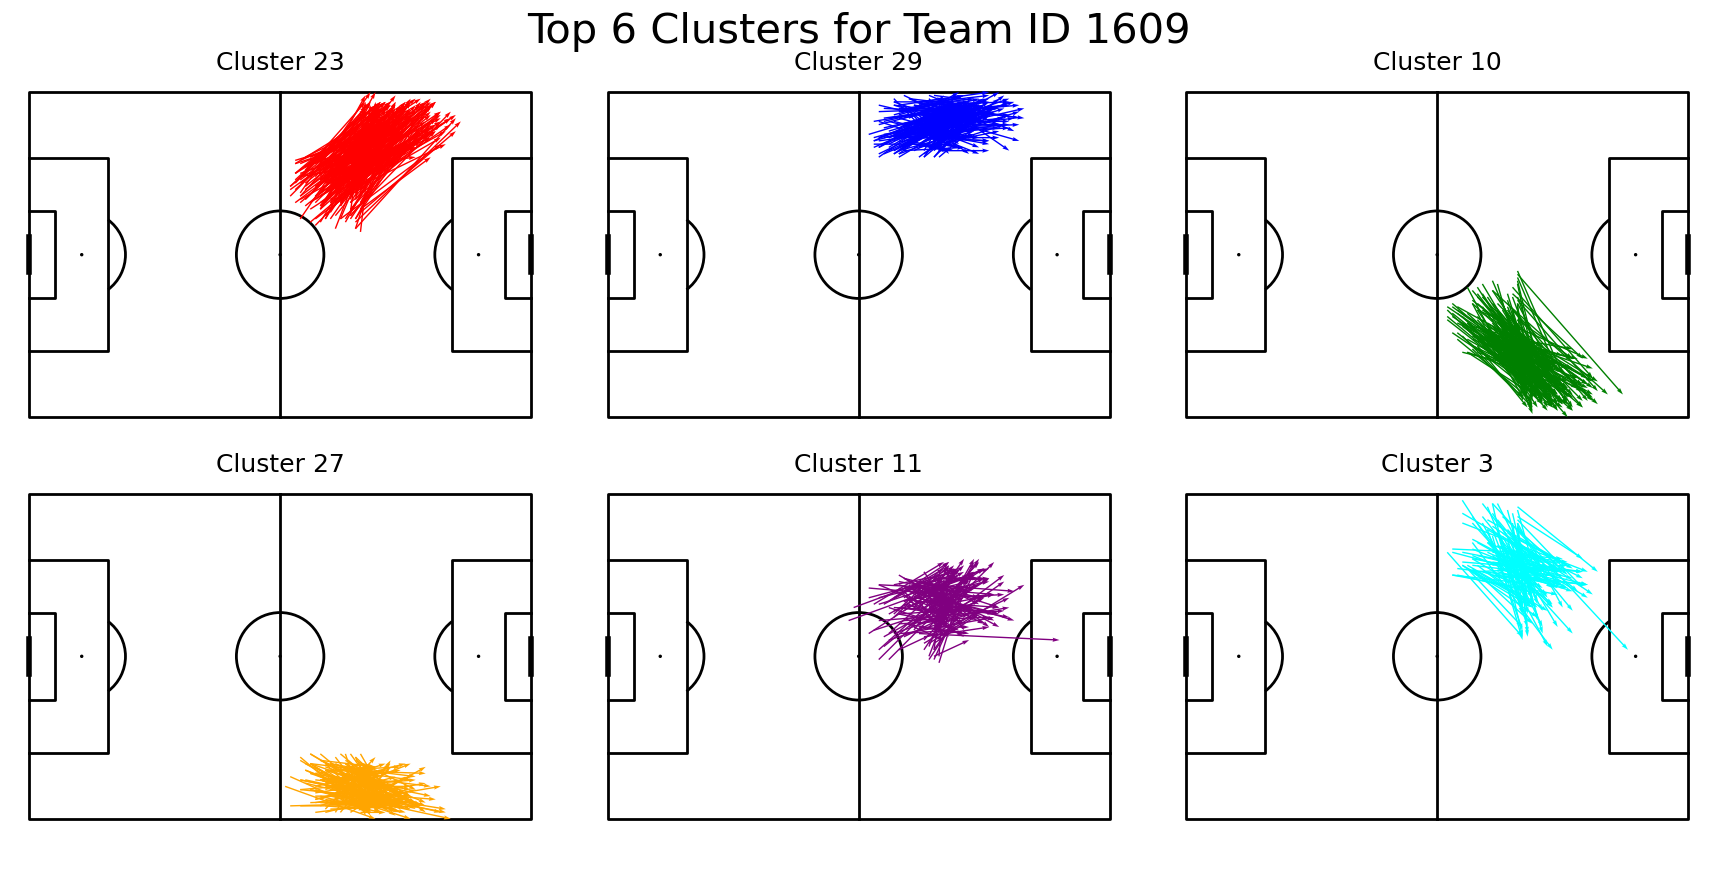

In [7]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Team ID 1609', ha='center', va='center', fontsize=30)
plt.show()

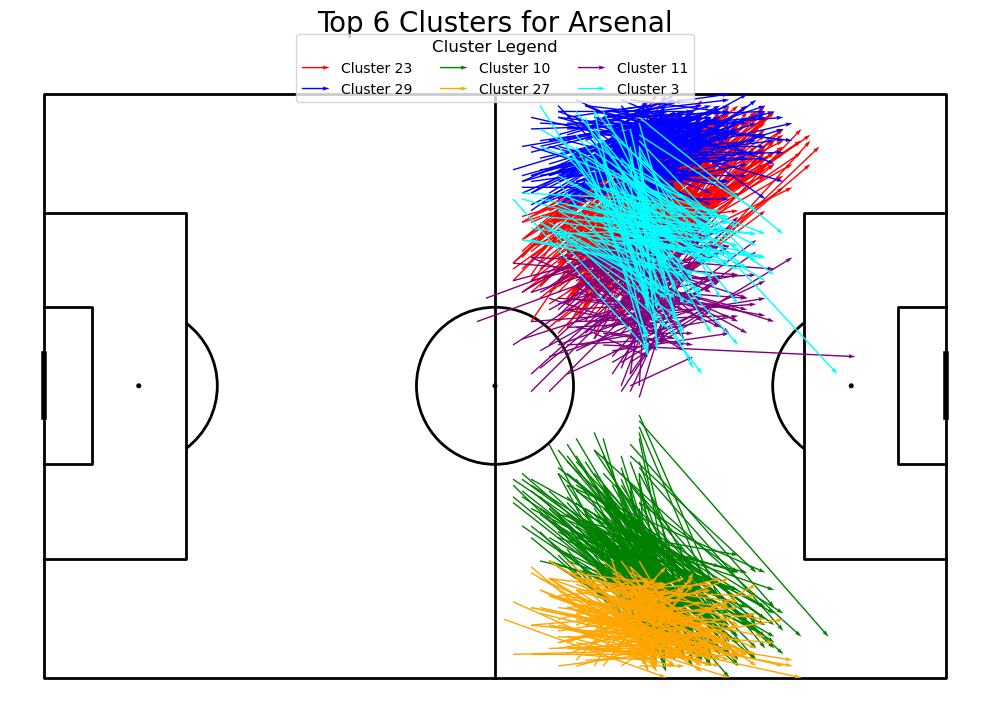

In [8]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up a single pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(10, 8))

# Plot passes for each cluster on the single pitch
for cluster in top_6_clusters:
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Plot the passes for the current cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1, label=f"Cluster {cluster+1}"
    )

# Add a legend for the clusters
legend = ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, 
    fontsize=10, frameon=True, title="Cluster Legend", title_fontsize=12
)

# Set the title for the visualization
ax.set_title('Top 6 Clusters for Arsenal', fontsize=20, pad=20)

plt.show()


In [15]:
# Top 6 clusters from earlier analysis
top_6_clusters = arsenal_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 11: short low pass from half left of center to the high half left of attacking third
Cluster 3: short primarily low pass from the left of the middle third to half left of the attacking third


#### Chelsea

In [16]:
chelse_passes = df[df["team_id"] == 1610]
chelse_passes.shape

(2520, 18)

In [17]:
top_6_clusters = chelse_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = chelse_passes[chelse_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(1079, 18)

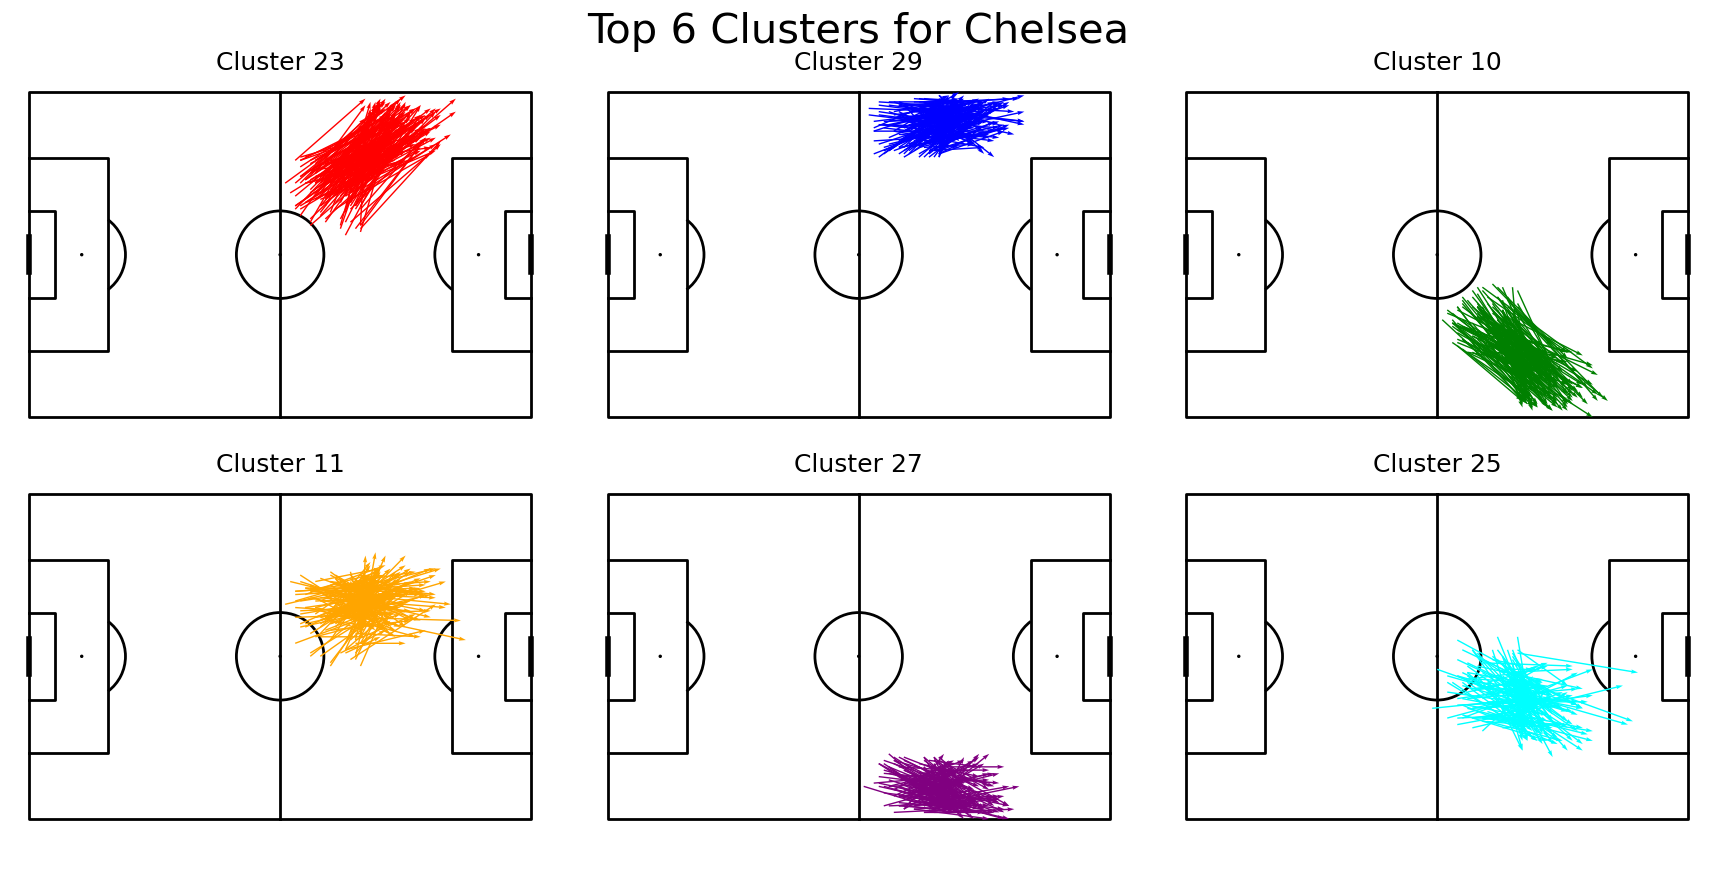

In [18]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Chelsea', ha='center', va='center', fontsize=30)
plt.show()

In [19]:
top_6_clusters = chelse_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 11: short low pass from half left of center to the high half left of attacking third
Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 25: short low pass from half right of center to the high half right of attacking third


#### Manchester City

In [20]:
city_passes = df[df["team_id"] == 1625]
city_passes.shape

(3229, 18)

In [21]:
top_6_clusters = city_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = city_passes[city_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(1526, 18)

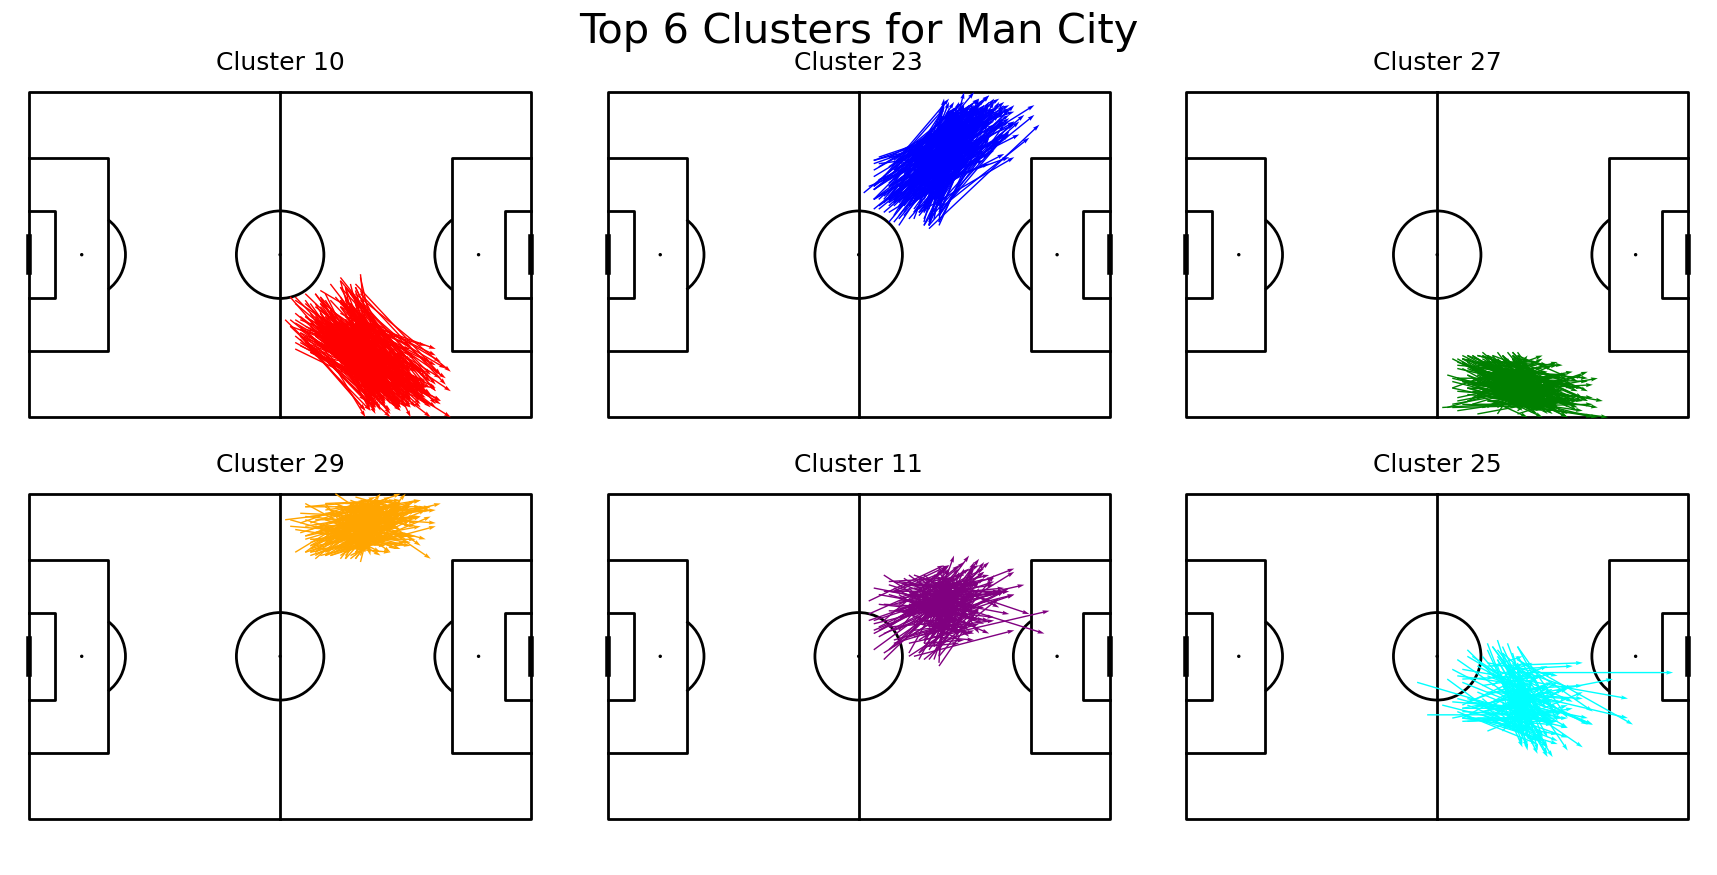

In [22]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Man City', ha='center', va='center', fontsize=30)
plt.show()

In [23]:
top_6_clusters = city_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 11: short low pass from half left of center to the high half left of attacking third
Cluster 25: short low pass from half right of center to the high half right of attacking third


#### Manchester United

In [24]:
united_passes = df[df["team_id"] == 1611]
united_passes.shape

(2387, 18)

In [25]:
top_6_clusters = united_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = united_passes[united_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(928, 18)

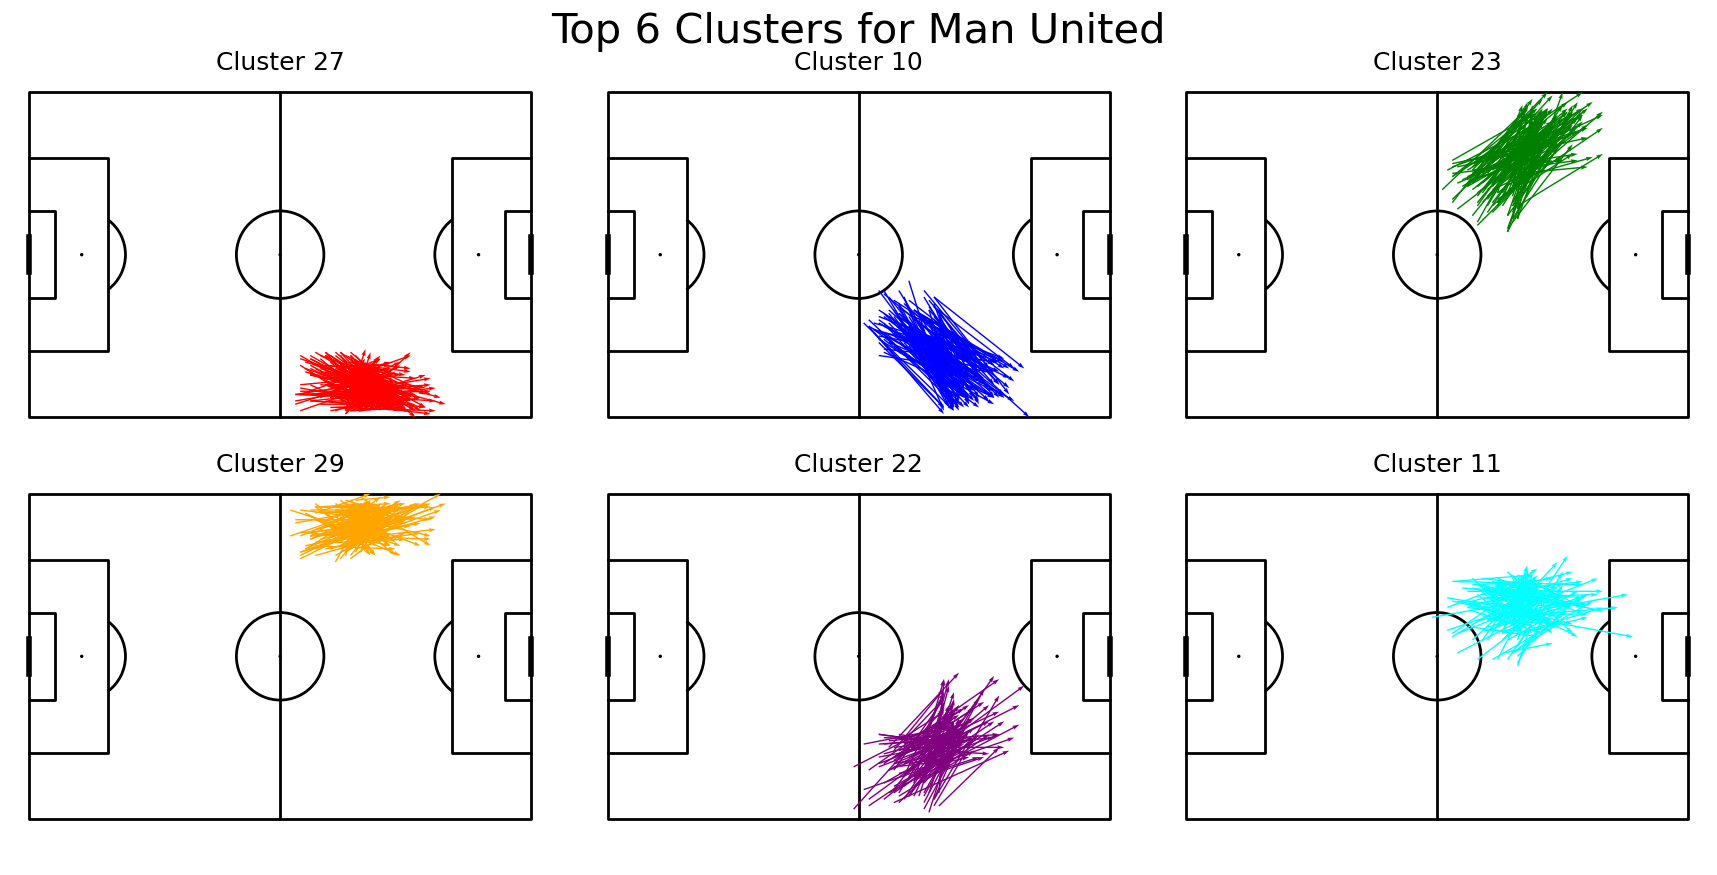

In [26]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Man United', ha='center', va='center', fontsize=30)
plt.show()

In [27]:
top_6_clusters = united_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 22: short primarily low pass from the right of the middle third to half right of the attacking third
Cluster 11: short low pass from half left of center to the high half left of attacking third


#### Liverpool

In [28]:
liverpool_passes = df[df["team_id"] == 1612]
liverpool_passes.shape

(3153, 18)

In [29]:
top_6_clusters = liverpool_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = liverpool_passes[liverpool_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(1254, 18)

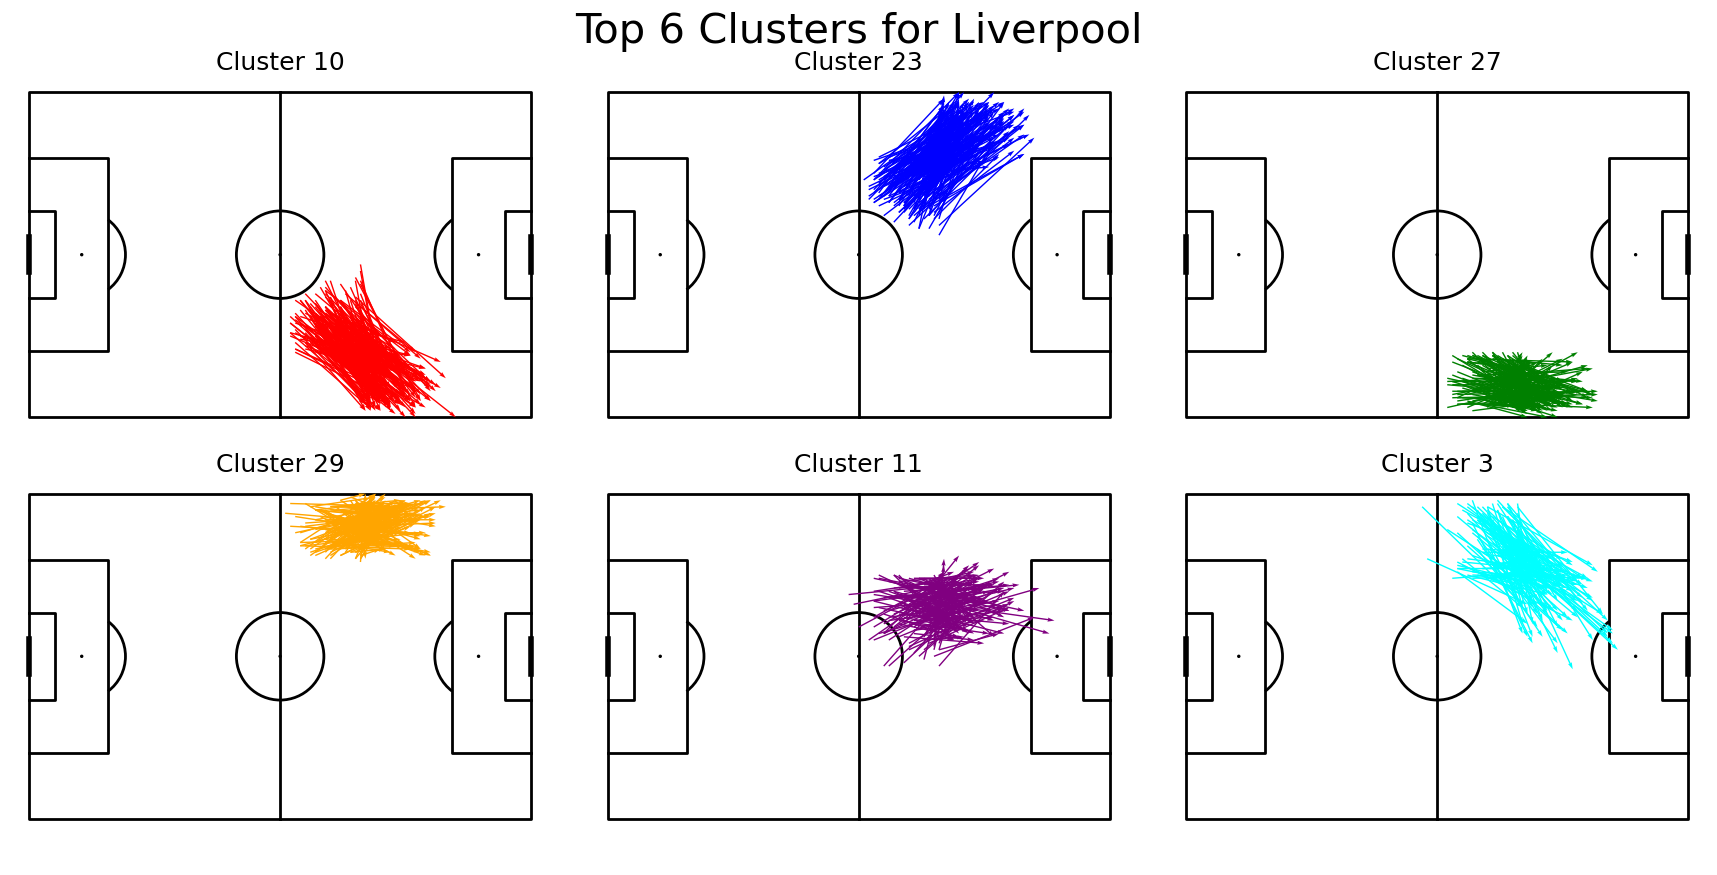

In [30]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Liverpool', ha='center', va='center', fontsize=30)
plt.show()

In [31]:
top_6_clusters = liverpool_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 11: short low pass from half left of center to the high half left of attacking third
Cluster 3: short primarily low pass from the left of the middle third to half left of the attacking third


#### Tottenham

In [34]:
tottenham_passes = df[df["team_id"] == 1624]
tottenham_passes.shape

(2188, 18)

In [35]:
top_6_clusters = tottenham_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = tottenham_passes[tottenham_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(886, 18)

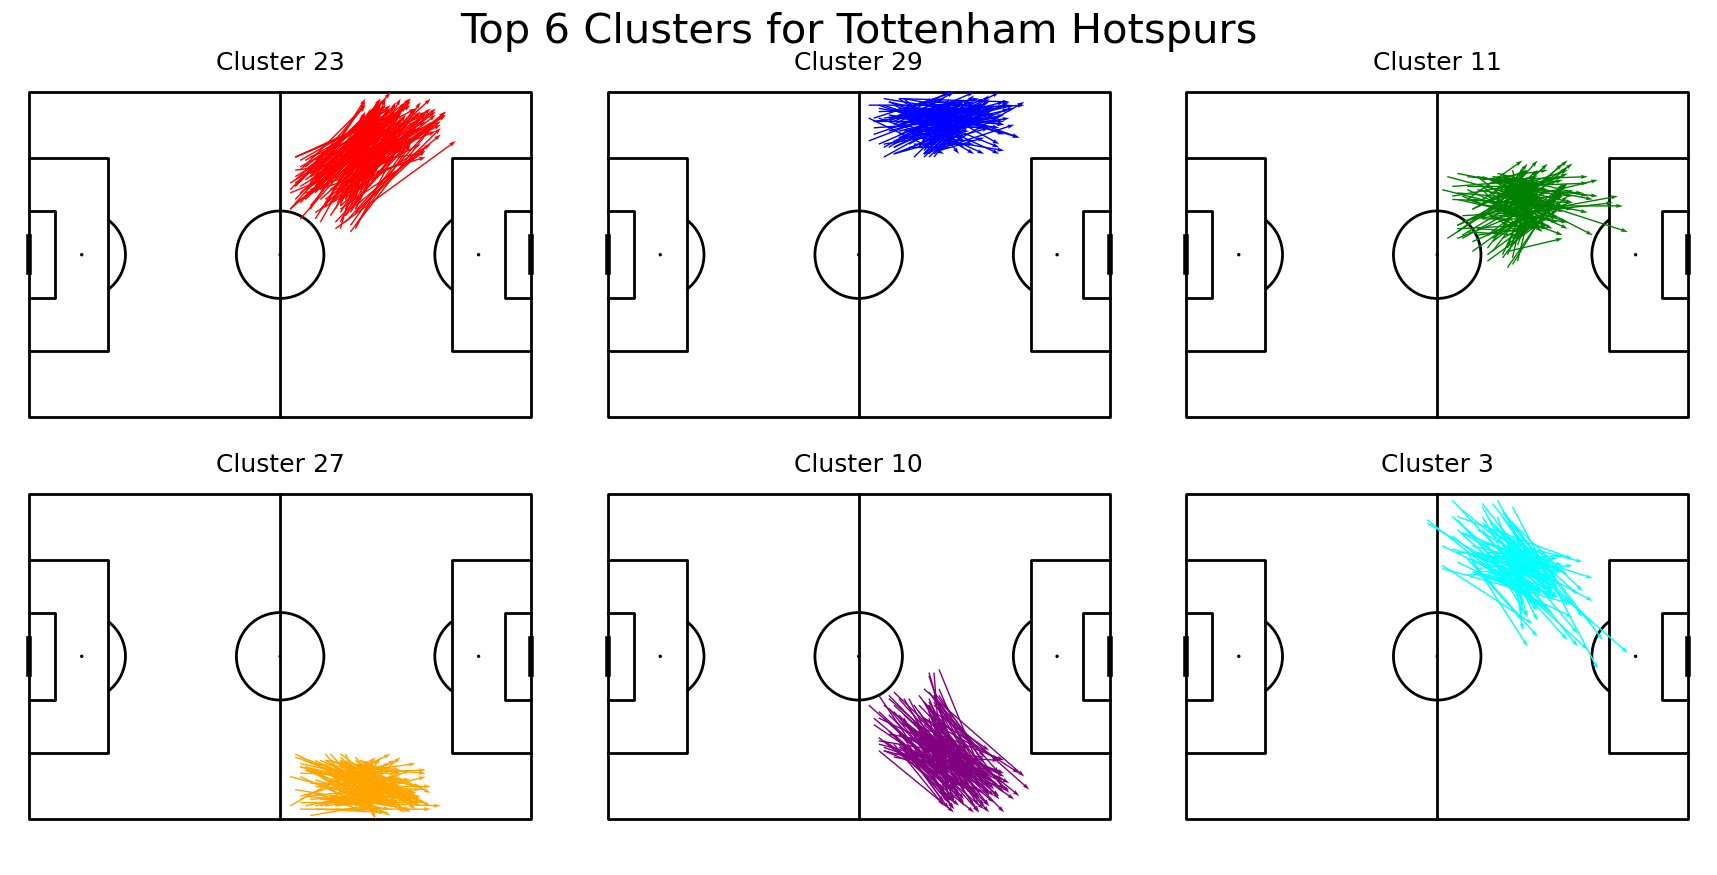

In [36]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Tottenham Hotspurs', ha='center', va='center', fontsize=30)
plt.show()

In [37]:
top_6_clusters = tottenham_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 11: short low pass from half left of center to the high half left of attacking third
Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 3: short primarily low pass from the left of the middle third to half left of the attacking third


### Bottom teams

#### Everton

In [38]:
everton_passes = df[df["team_id"] == 1623]
everton_passes.shape

(2157, 18)

In [39]:
top_6_clusters = everton_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = everton_passes[everton_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(726, 18)

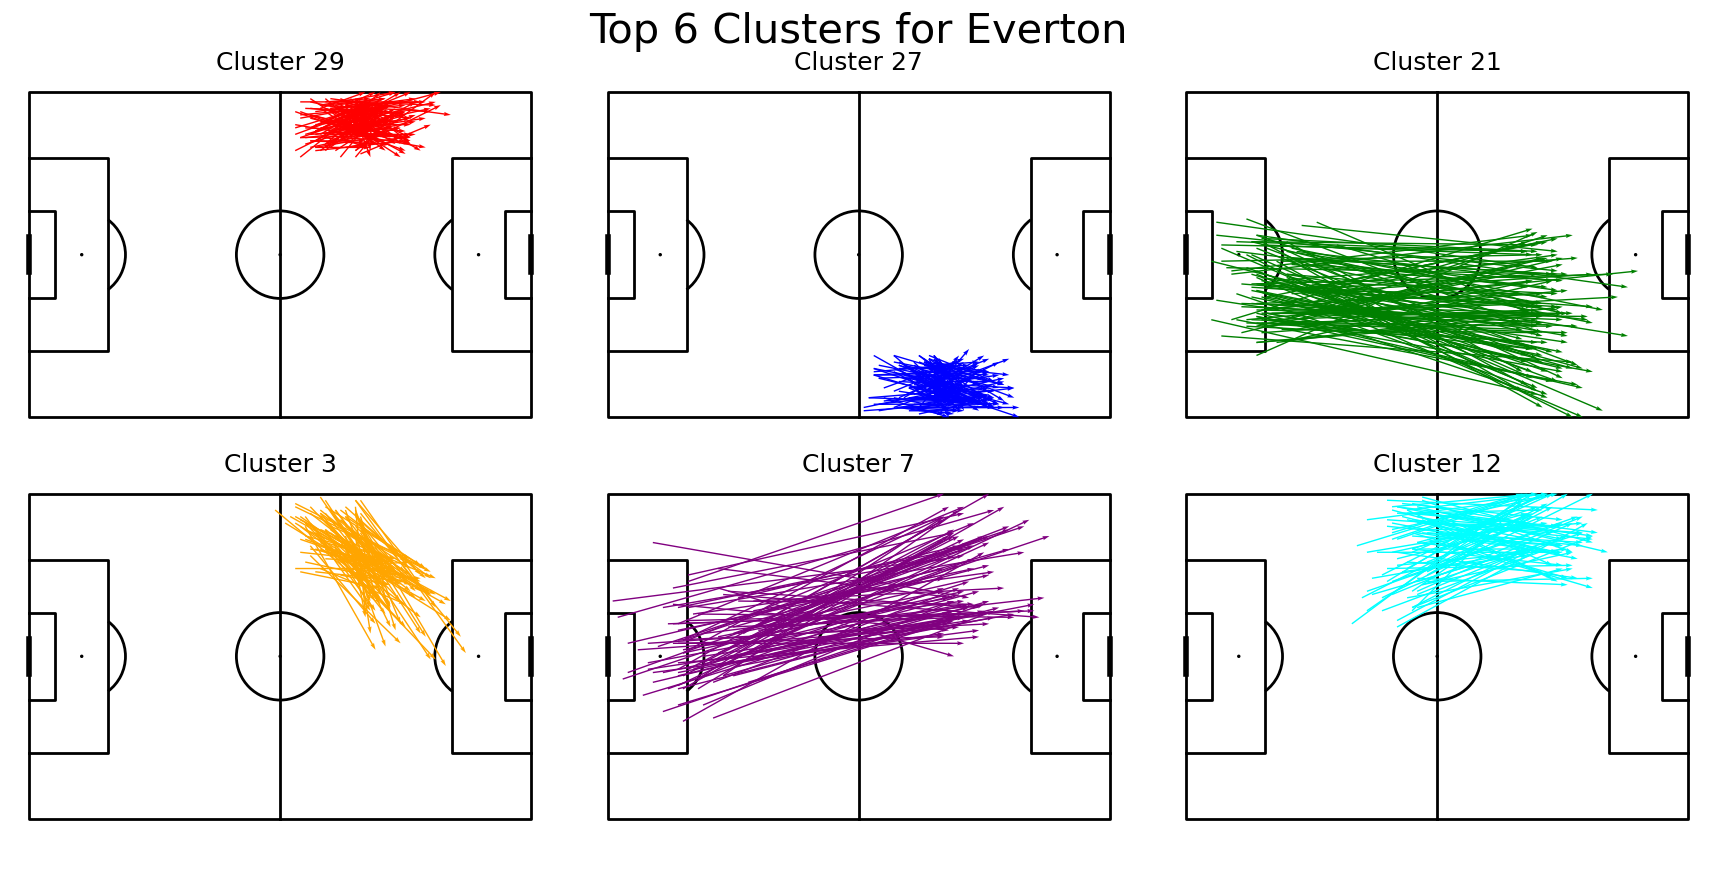

In [40]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Everton', ha='center', va='center', fontsize=30)
plt.show()

In [41]:
top_6_clusters = everton_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 21: long high pass from defending third to right half of the attacking third
Cluster 3: short primarily low pass from the left of the middle third to half left of the attacking third
Cluster 7: long high pass from defending third to left half of the attacking third
Cluster 12: medium mixed height pass down the left hand side from own half to the start of the attacking third


#### Leeds

In [42]:
leeds_passes = df[df["team_id"] == 1630]
leeds_passes.shape

(1532, 18)

In [43]:
top_6_clusters = leeds_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = leeds_passes[leeds_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(575, 18)

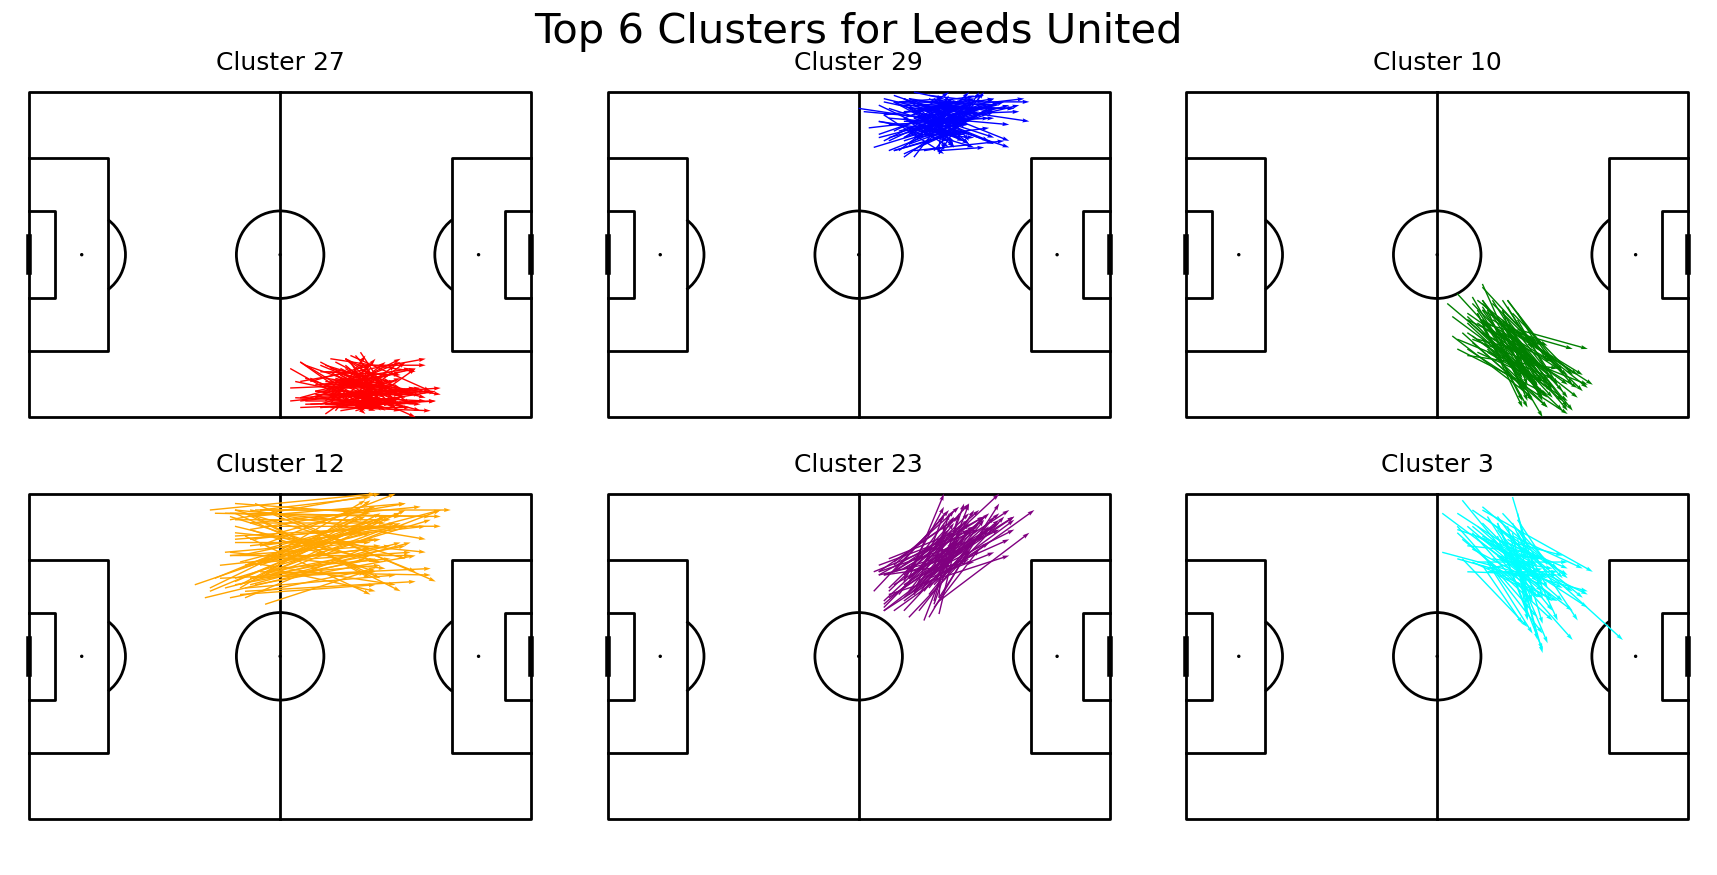

In [44]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Leeds United', ha='center', va='center', fontsize=30)
plt.show()

In [45]:
top_6_clusters = leeds_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 12: medium mixed height pass down the left hand side from own half to the start of the attacking third
Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 3: short primarily low pass from the left of the middle third to half left of the attacking third


#### Burnley

In [46]:
burnley_passes = df[df["team_id"] == 1646]
burnley_passes.shape

(1489, 18)

In [47]:
top_6_clusters = burnley_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = burnley_passes[burnley_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(483, 18)

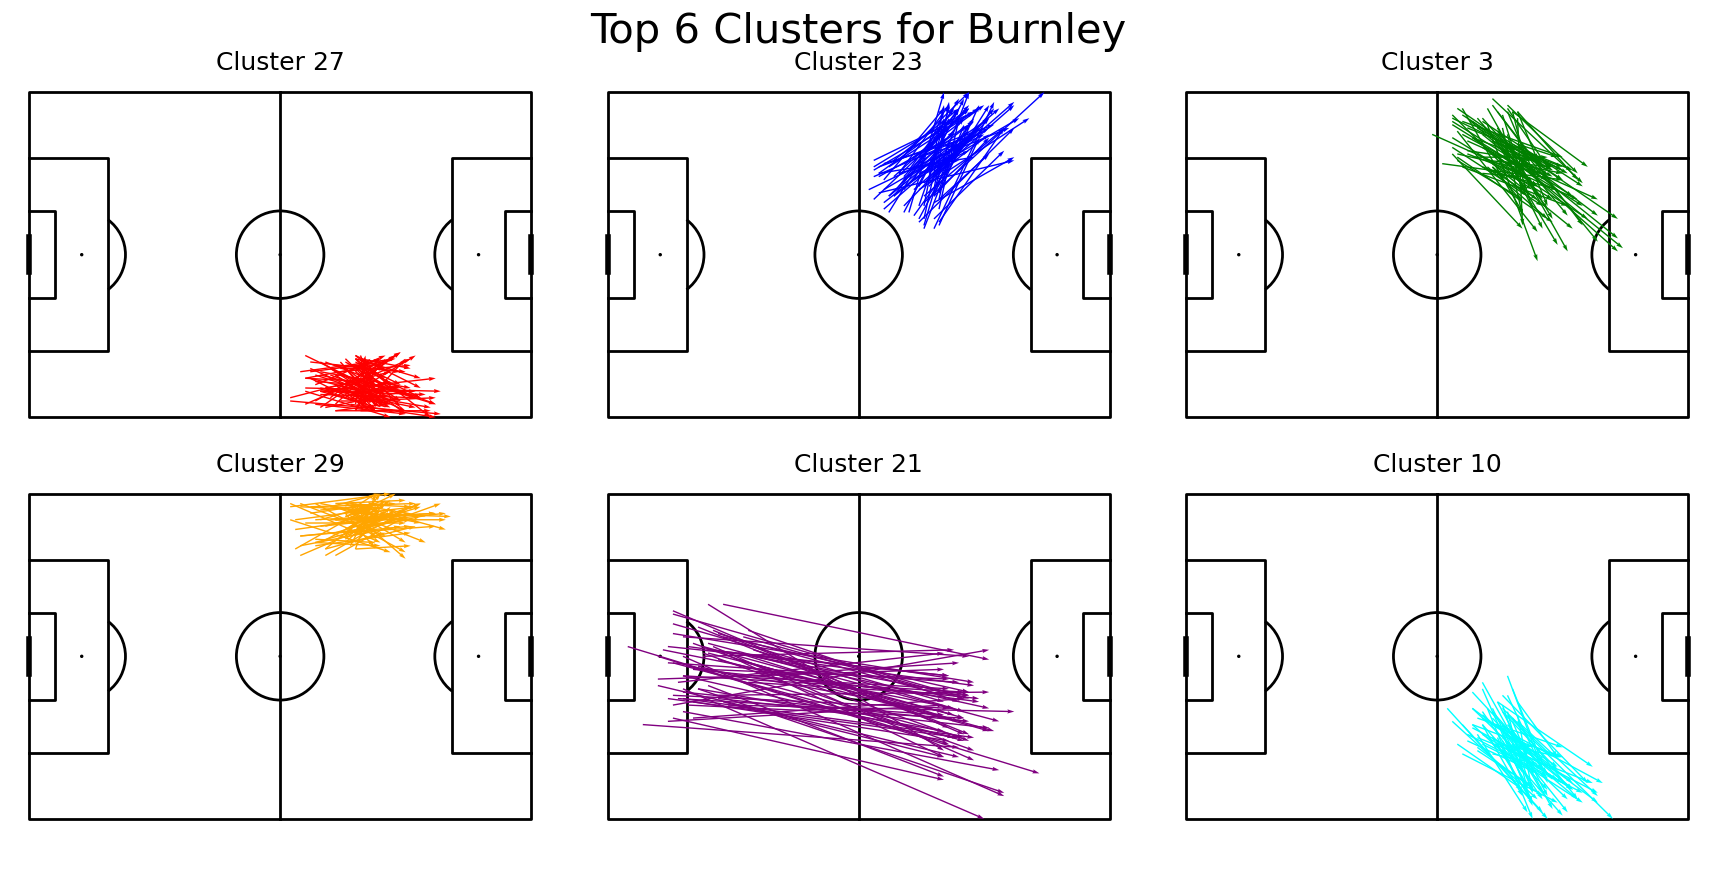

In [49]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Burnley', ha='center', va='center', fontsize=30)
plt.show()

In [50]:
top_6_clusters = burnley_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 3: short primarily low pass from the left of the middle third to half left of the attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 21: long high pass from defending third to right half of the attacking third
Cluster 10: short low pass from half right of center to the high right of the attacking third


#### Southampton

In [51]:
southampton_passes = df[df["team_id"] == 1619]
southampton_passes.shape

(1413, 18)

In [52]:
top_6_clusters = southampton_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = southampton_passes[southampton_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(510, 18)

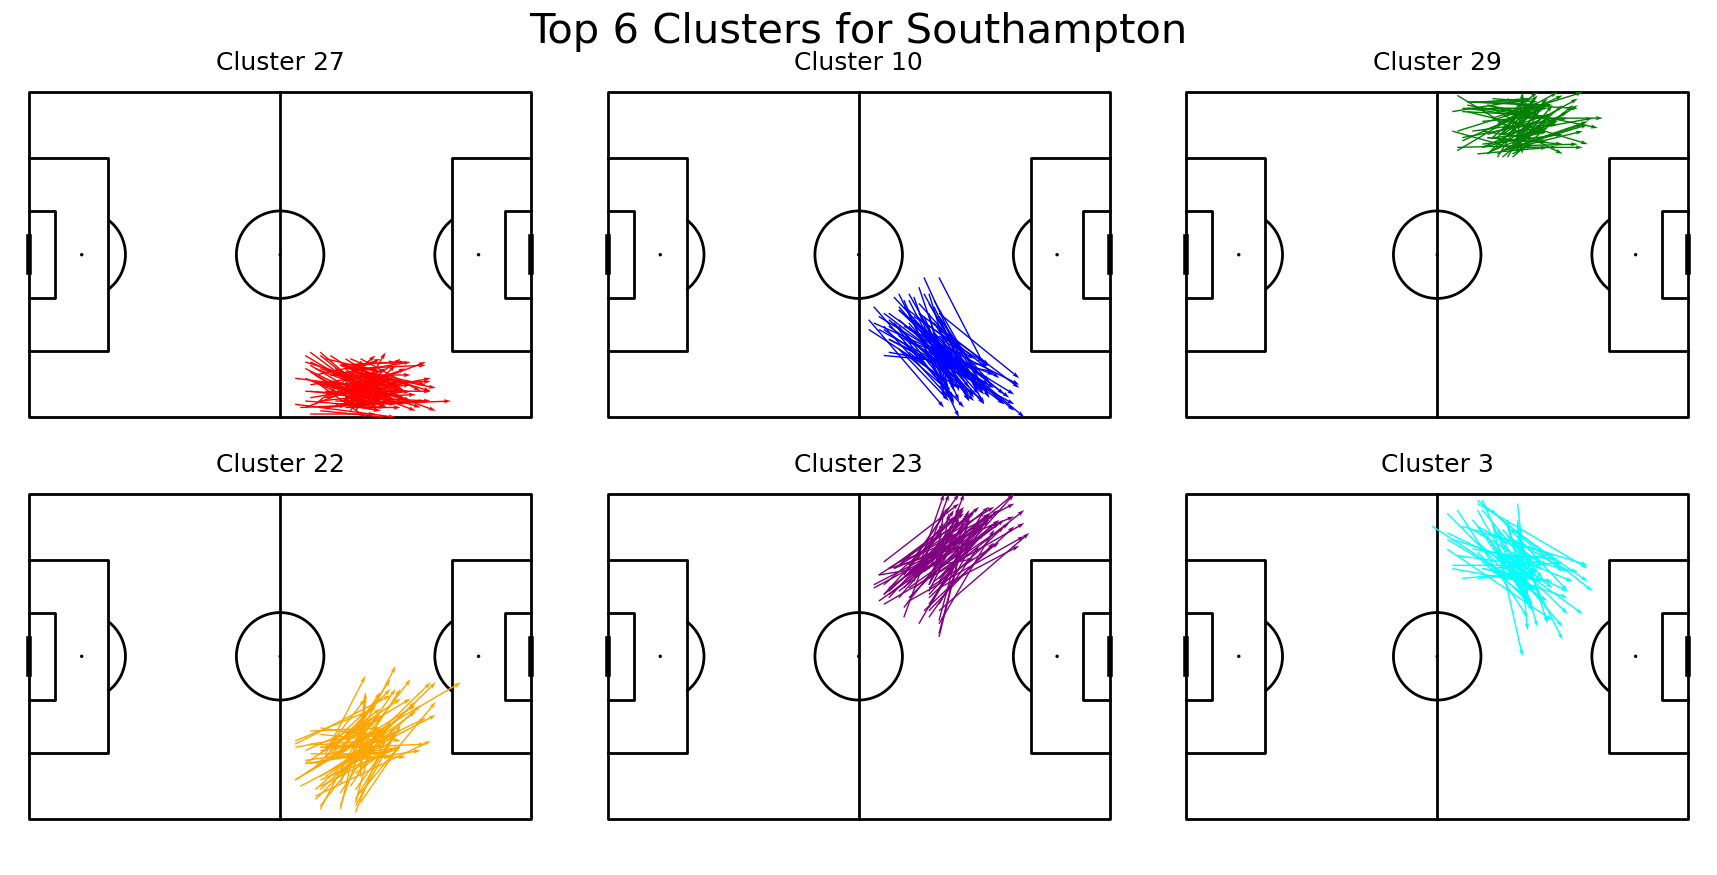

In [53]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Southampton', ha='center', va='center', fontsize=30)
plt.show()

In [54]:
top_6_clusters = southampton_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 22: short primarily low pass from the right of the middle third to half right of the attacking third
Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 3: short primarily low pass from the left of the middle third to half left of the attacking third


#### Luton Town

In [55]:
luton_passes = df[df["team_id"] == 1660]
luton_passes.shape

(590, 18)

In [56]:
top_6_clusters = luton_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = luton_passes[luton_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(232, 18)

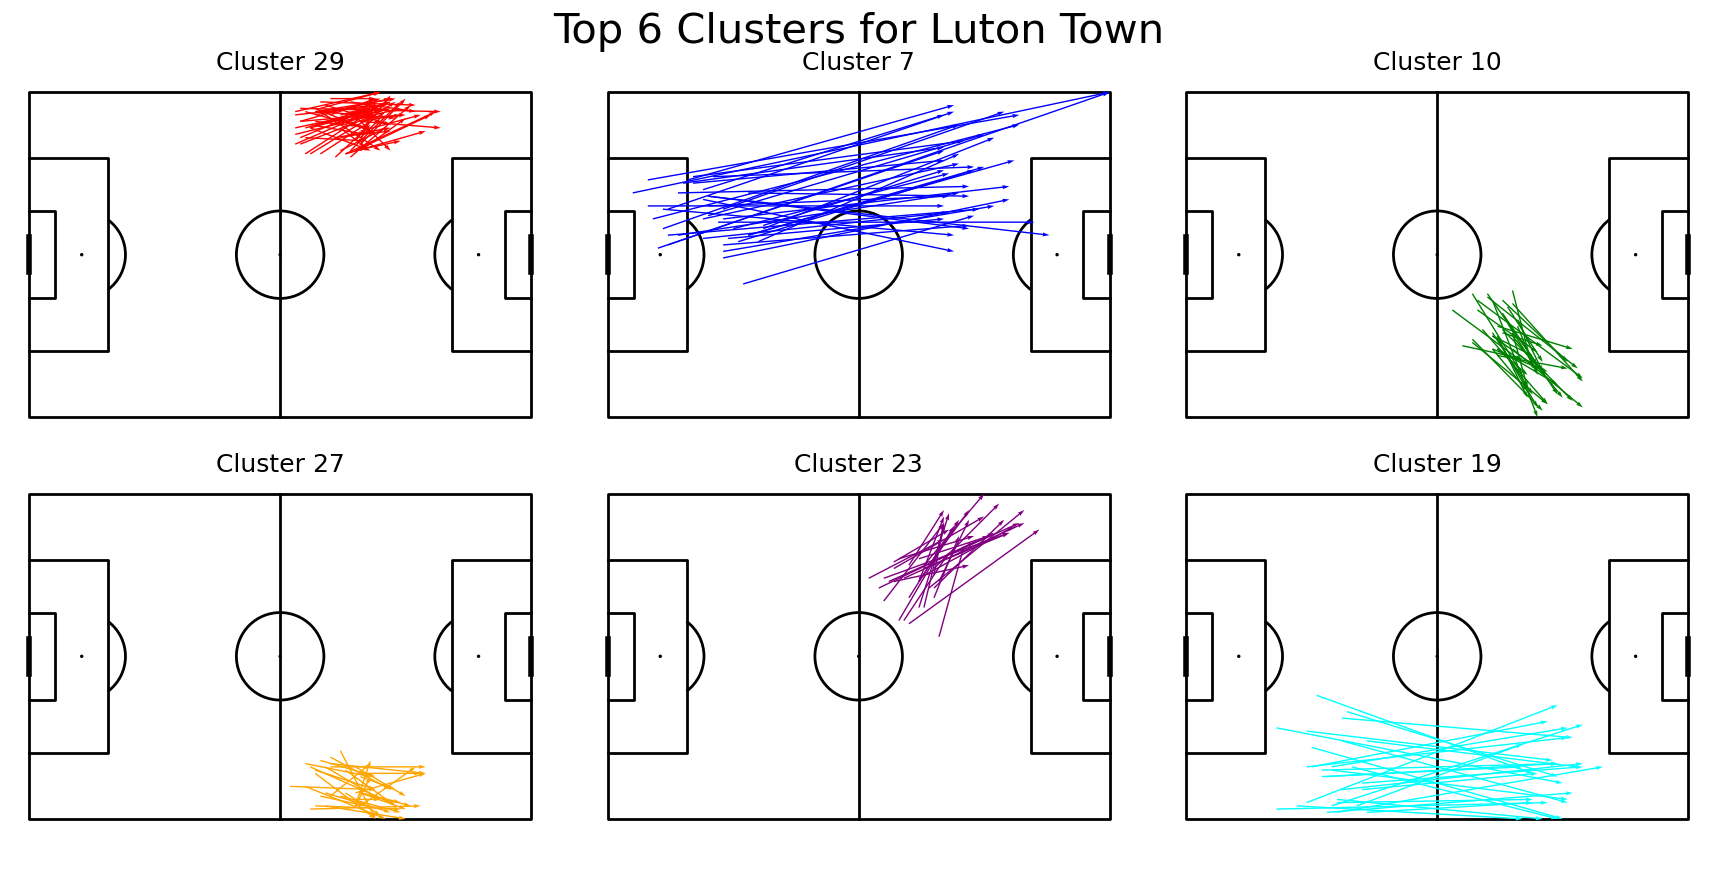

In [57]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Luton Town', ha='center', va='center', fontsize=30)
plt.show()

In [58]:
top_6_clusters = luton_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 7: long high pass from defending third to left half of the attacking third
Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 19: medium to long high pass from right side of defending or middle third to high right side of attacking third


#### Watford

In [59]:
watford_passes = df[df["team_id"] == 1644]
watford_passes.shape

(642, 18)

In [60]:
top_6_clusters = watford_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = watford_passes[watford_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(218, 18)

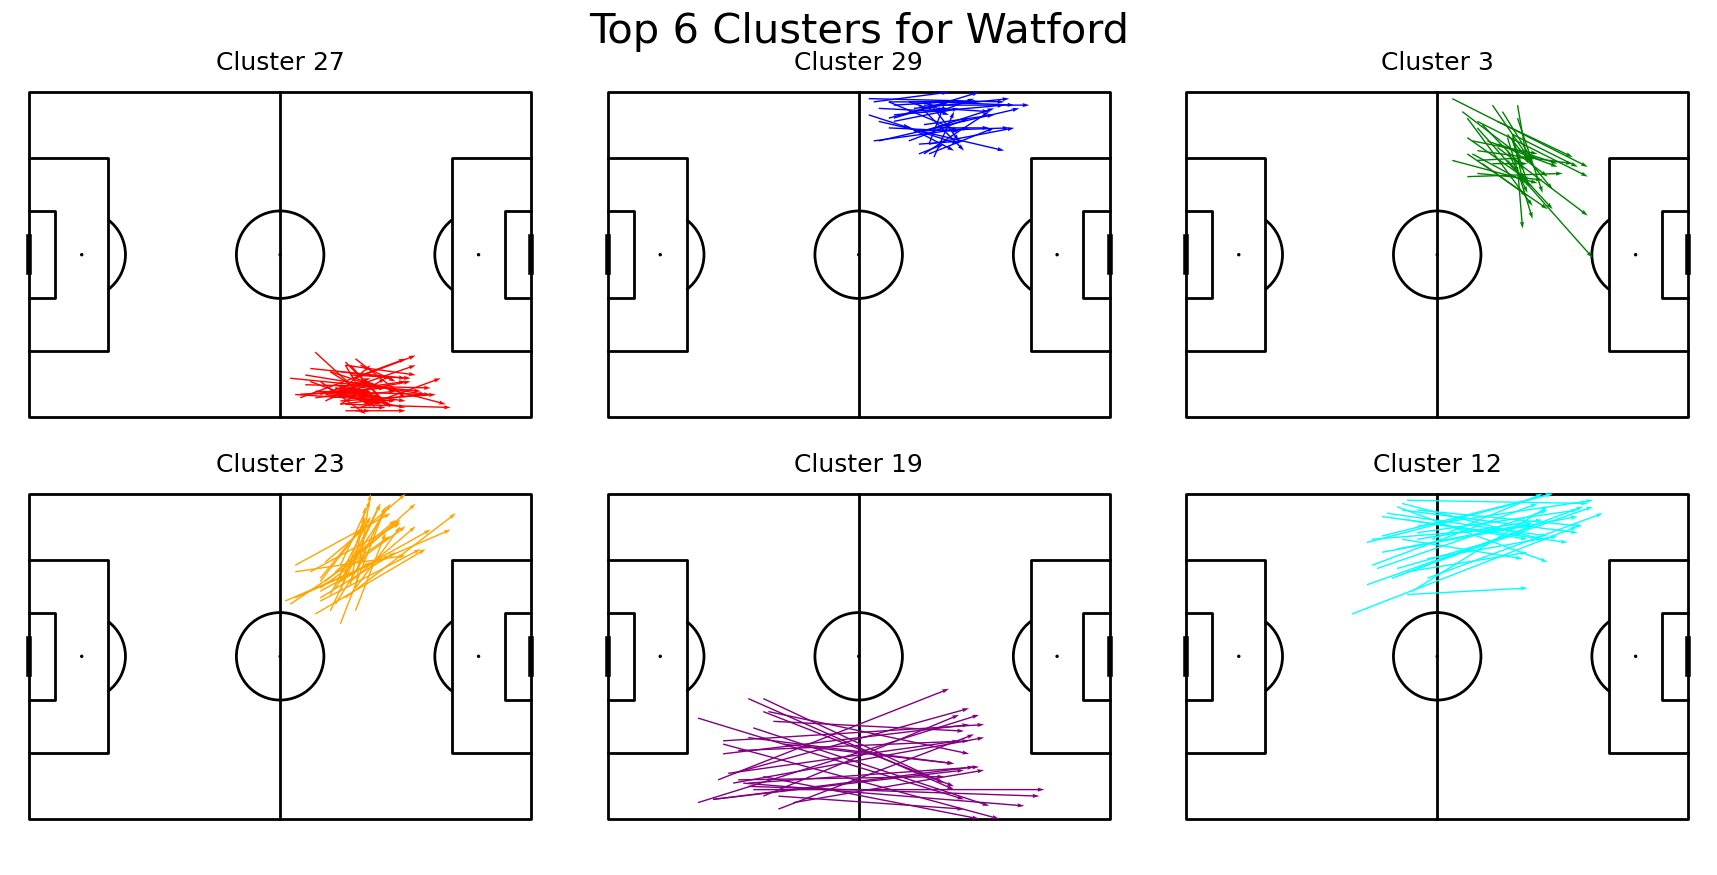

In [61]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Watford', ha='center', va='center', fontsize=30)
plt.show()

In [62]:
top_6_clusters = watford_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 3: short primarily low pass from the left of the middle third to half left of the attacking third
Cluster 23: short low pass from half left of center to the high left of the attacking third
Cluster 19: medium to long high pass from right side of defending or middle third to high right side of attacking third
Cluster 12: medium mixed height pass down the left hand side from own half to the start of the attacking third


#### Norwich City

In [63]:
norwich_passes = df[df["team_id"] == 1626]
norwich_passes.shape

(621, 18)

In [64]:
top_6_clusters = norwich_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = norwich_passes[norwich_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(208, 18)

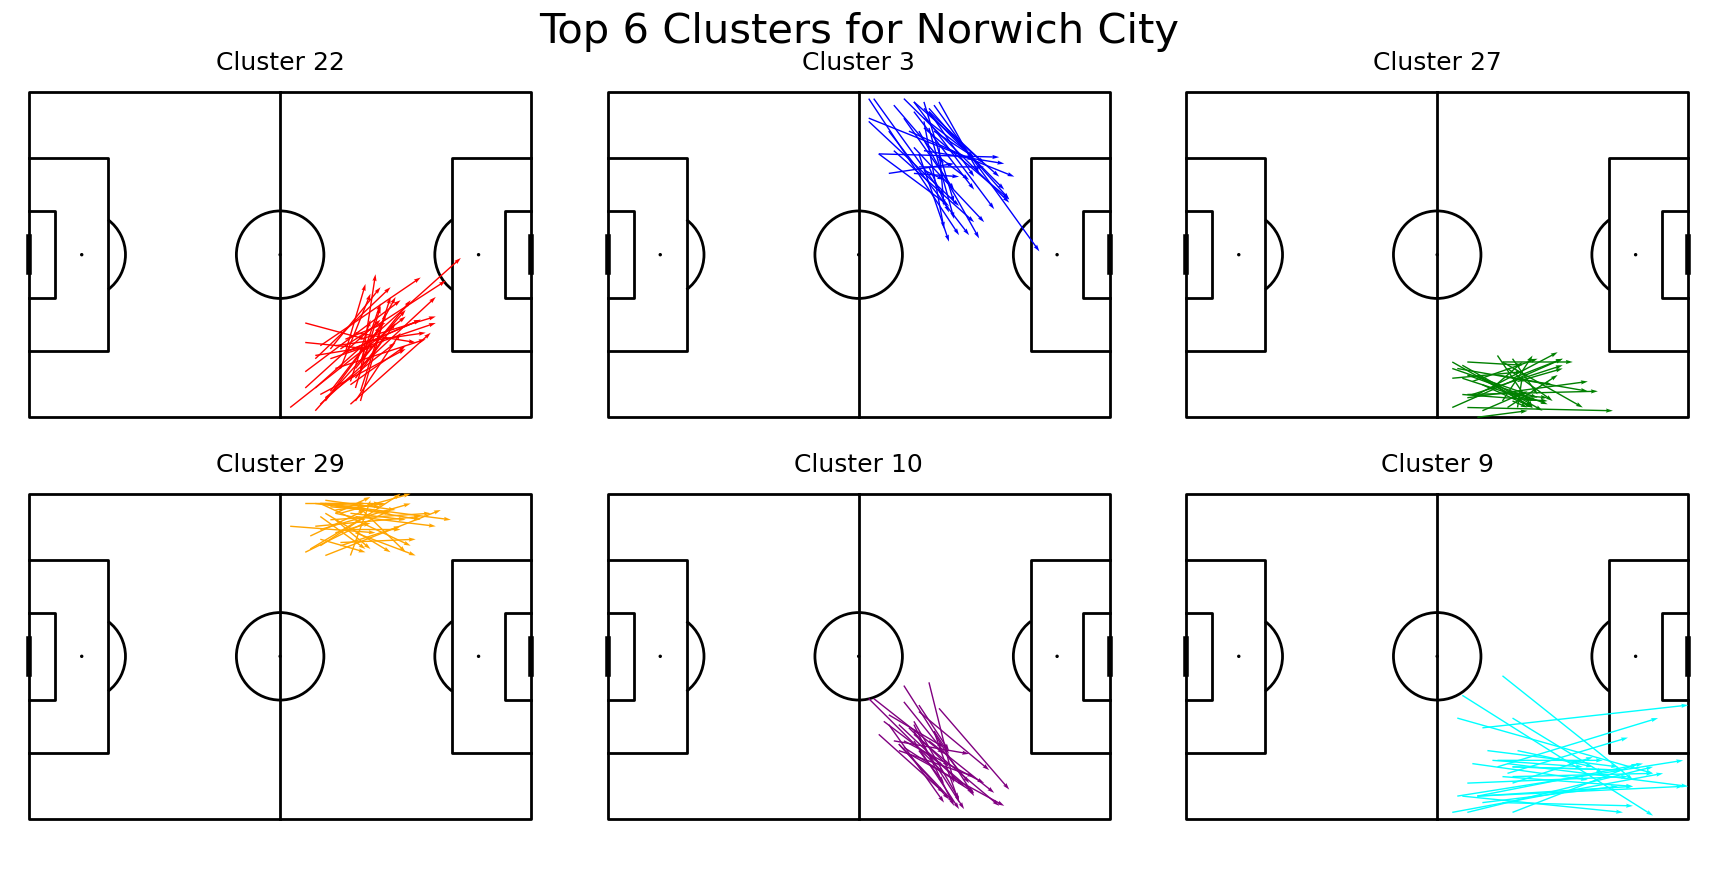

In [65]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Norwich City', ha='center', va='center', fontsize=30)
plt.show()

In [66]:
top_6_clusters = norwich_passes["label"].value_counts().head(6).index

# Adjust for label offset and fetch descriptions
for cluster in top_6_clusters:
    description = cluster_descriptions[cluster]  
    print(f"Cluster {cluster+1}: {description}")

Cluster 22: short primarily low pass from the right of the middle third to half right of the attacking third
Cluster 3: short primarily low pass from the left of the middle third to half left of the attacking third
Cluster 27: short low pass down the right hand side from middle to attacking third
Cluster 29: short low pass down the left hand side from middle to attacking third
Cluster 10: short low pass from half right of center to the high right of the attacking third
Cluster 9: medium primarily low pass from the end of right side middle third to deep right of the attacking third


## Interpretacija rezultatov

### Najpogostejši tipi podaj

**Opazimo, da se določene gruče podaj pojavljaj pri (praktično) vseh ekipah:**
* 29, 27 - gre za kratko nizko podajo ob strani igrišča za prenos žoge iz srednje v napadalno cono
* 10, 23 - gre za podajo iz pol desne oz. pol leve strani centra na desno oz levo stran začetka napadalne cone

**Najdemo tudi gruče, ki se pojavljajo zmerno pri obeh skupinah ekip:**
* 3 - podaja iz leve strani srednje cone v pol levo stran napadalne cone (medprostor)

**Nekare gruče podaj najdemo le pri boljših ekipah:**
* Vse top 6 ekipe se odločajo za podaje iz gruče 11, nekatere tudi iz gruče 25 - gre za iskanje medprostorov skozi sredino. Zanimivo se nobena od teh gruč ne pojavi med slabšimi ekipami niti enkrat. Iz tega lahko potrdimo sklepanje, da lahko skozi sredino igrajo le močnejše ekipe, ki prevladujejo v posesti

**Veliko manj pogostih gruč pa najdemo prav pri slabših ekipah:**
* 7, 9, 12, 19, 21 - gre predvsem za srednje dolge in dolge podaje, katere so pogosto tudi visoke, kar je še en pokazatelj, da slabše ekipe pogosteje računajo na preskok igro.

**Dodatne podaje:**
* 22 - gruča, ki se občasno pojavi pri obeh skupinah ekip, gre za zrcaljeno sliko gruče 3, katera se pojavlja pogosteje. Iz tega lahko sklepamo, da ekipe pogosteje igrajo žogo naprej proti sredini iz leve strani kot iz desne

# Analiza Manchester City : Chelsea

**City se najpogosteje poslužuje podaj tipa:**
* 10, 23, 27, 29, 11, 25

**Chelsea pa:**
* 23, 29, 10, 11, 27, 25

Zanimivo gre za **EDINI** ekipi iz analize, ki imata med najpogostejšimi gručami podaj 11 **in 25**. Pomeni, da obe ekipi strmita k prehodu v zadnjo tretino s podajami skozi sredino ter iskanjem medprostorov. Pravtako gre za edini ekipi, kateri imata med 6 najpogostejšimi gručami podaj, enake gruče.

City se poleg podaj skozi sredino največ poslužuje podaj iz polleve oz. poldesne strani centra na stran v začetek napadalne cone. Iz tega lahko razberemo, da so za izgradnjo cityjevih napadov najpomembnejši centralni vezni igralci (DCM, CM).  Poleg podaj iz centralne cone, se City (kot praktično vse ekipe) za prehod v tretjo cono poslužuje kratkih podaj ob strani oz. ob obeh out linijah. Tako je razvidno, da se City za prenos žoge v tretjo cono najpogosteje zanaša na svoje krilne igralce, kar je razvidno iz gruč 10, 23, 27, 29.

## Grupiranje podaj najnevarnejših igralcev glede na xT

### Manchester City passes

In [67]:
df = pd.read_csv("data/clustered_passes_HIGH_1.csv")
city_passes = df[df["team_id"] == 1625]
city_passes.head(3)

id  start_x  start_y  end_x  end_y  pass_length  successful  \
0   2109521393     69.3     3.40   96.6   8.16    27.711867        True   
11  1423400109     48.3    56.44   75.6  54.40    27.376114        True   
30  1156090776     60.9     4.08   77.7   7.48    17.140595        True   

    pass_high  player_id  team_id  pass_recipient_id player_position  season  \
0       False     447205     1625             550459             LWF    2023   
11      False     364860     1625                 -1            RDMF    2022   
30      False     134102     1625              14808              LB    2021   

    long_pass  possession_id  minute     angle  label  
0       False     2109521364      82  0.172624      8  
11      False     1423400106      38 -0.074587     11  
30      False     1156090767      71  0.199684     26

In [68]:
city_passes.shape

(3229, 18)

In [108]:
city_passes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3229 entries, 0 to 44845
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3229 non-null   int64  
 1   start_x            3229 non-null   float64
 2   start_y            3229 non-null   float64
 3   end_x              3229 non-null   float64
 4   end_y              3229 non-null   float64
 5   pass_length        3229 non-null   float64
 6   successful         3229 non-null   bool   
 7   pass_high          3229 non-null   bool   
 8   player_id          3229 non-null   int64  
 9   team_id            3229 non-null   int64  
 10  pass_recipient_id  3229 non-null   int64  
 11  player_position    3224 non-null   object 
 12  season             3229 non-null   int64  
 13  long_pass          3229 non-null   bool   
 14  possession_id      3229 non-null   int64  
 15  minute             3229 non-null   int64  
 16  angle              3229 non-

### City Players

In [71]:
df_players = duckdb.sql(f"""SELECT * FROM 'data/players.parquet' """).df()
df_players.shape

(940, 7)

In [72]:
df_players.head(1)

player_id short_name birth_date   foot        role passport  \
0       8319  J. Milner 1986-01-04  right  Midfielder  England   

   __index_level_0__  
0                  0

### Vezni igralci

#### Kevin De Bruyne

In [74]:
# Filter the DataFrame to find the row for 'K. De Bruyne'
de_bruyne_row = df_players[df_players['short_name'] == 'K. De Bruyne']
de_bruyne_row

player_id    short_name birth_date   foot        role passport  \
596      38021  K. De Bruyne 1991-06-28  right  Midfielder  Belgium   

     __index_level_0__  
596                596

In [75]:
deBruyne_passes = city_passes[city_passes["player_id"] == 38021]
deBruyne_passes.head(3)

id  start_x  start_y  end_x  end_y  pass_length  successful  \
288   1143336202    55.65    38.76  70.35  46.24    16.493647        True   
983   1181581319    66.15    65.28  75.60  65.28     9.450000        True   
1094  1634041276    59.85    36.72  78.75  59.84    29.862090        True   

      pass_high  player_id  team_id  pass_recipient_id player_position  \
288       False      38021     1625             135903           RCMF3   
983       False      38021     1625              11051           RCMF3   
1094      False      38021     1625              26150             AMF   

      season  long_pass  possession_id  minute     angle  label  
288     2021      False     1143336200      90  0.470697     10  
983     2021      False     1181581265      88  0.000000     28  
1094    2022      False     1634041264      70  0.885491      0

In [76]:
top_6_clusters = deBruyne_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = deBruyne_passes[deBruyne_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(81, 18)

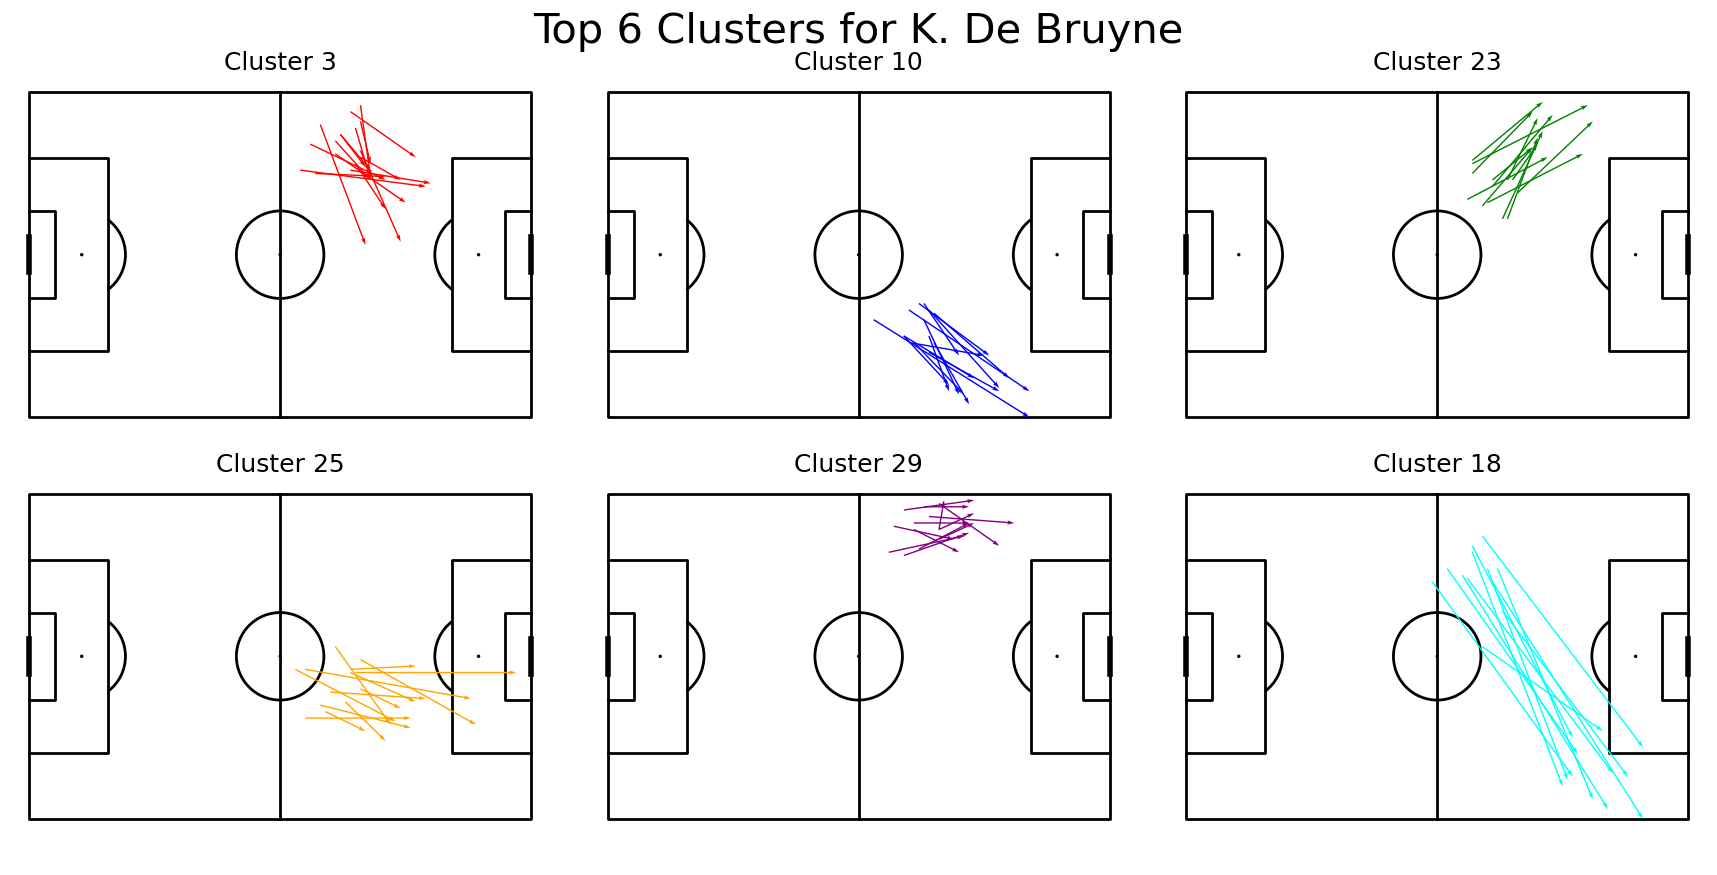

In [77]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for K. De Bruyne', ha='center', va='center', fontsize=30)
plt.show()

#### Rodri

In [78]:
rodri_row = df_players[df_players['short_name'] == 'Rodri']
rodri_row

player_id short_name birth_date   foot        role passport  \
139     364860      Rodri 1996-06-22  right  Midfielder    Spain   

     __index_level_0__  
139                139

In [79]:
rodri_passes = city_passes[city_passes["player_id"] == 364860]
rodri_passes.shape

(490, 18)

In [80]:
top_6_clusters = rodri_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = rodri_passes[rodri_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(257, 18)

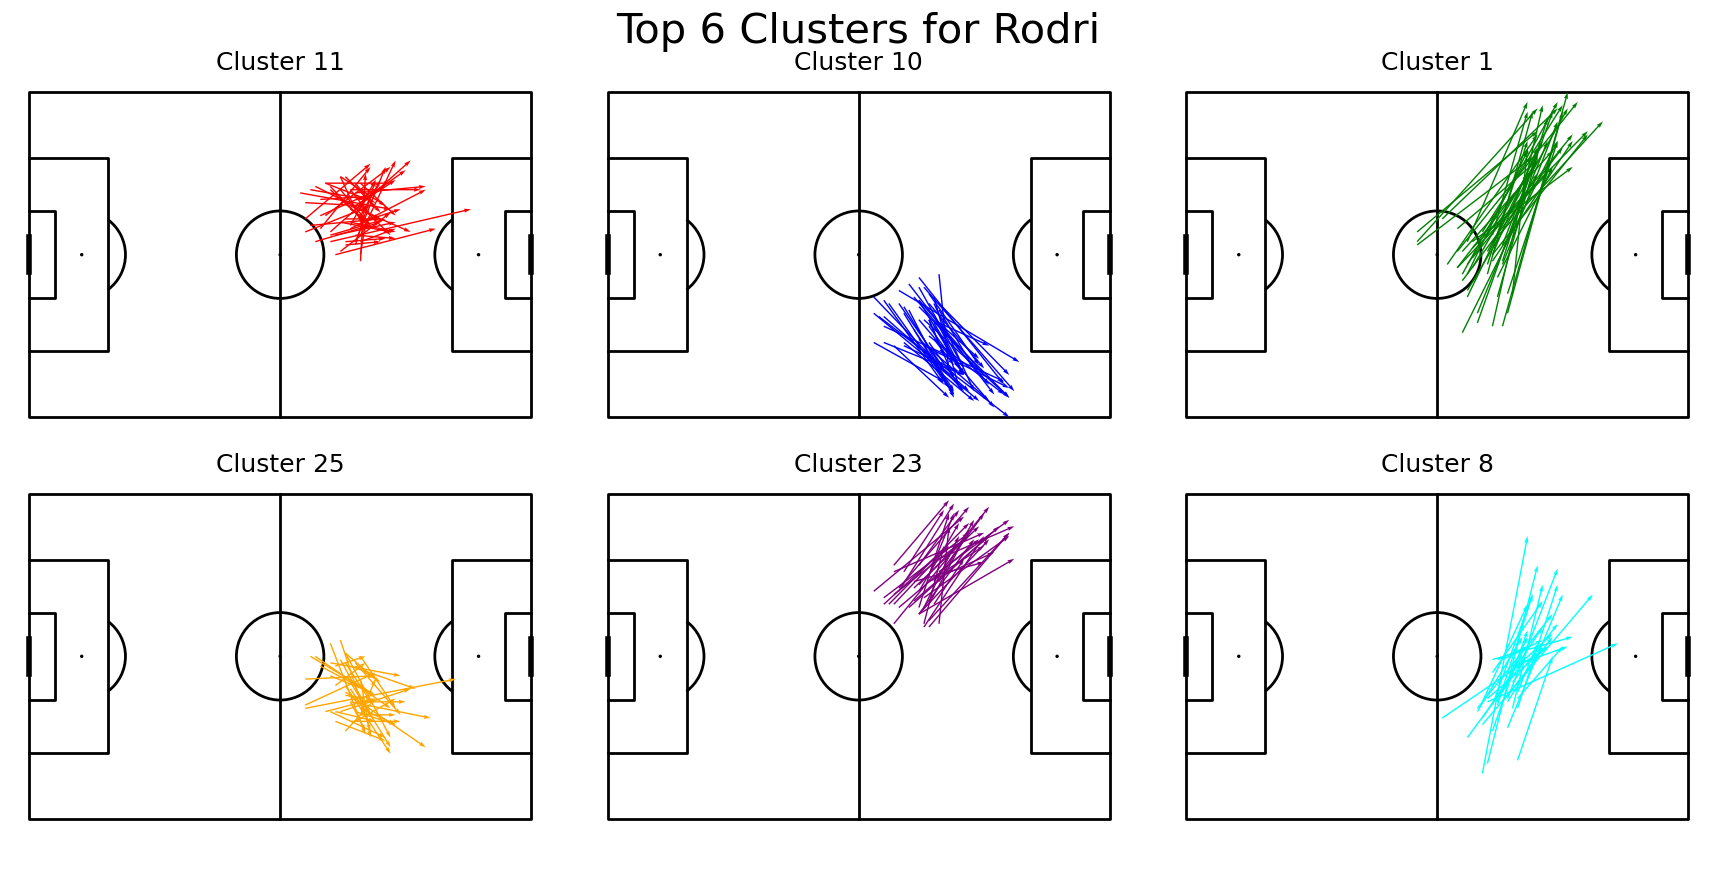

In [82]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for Rodri', ha='center', va='center', fontsize=30)
plt.show()

#### Phil Foden

In [86]:
foden_row = df_players[df_players['short_name'] == 'P. Foden']
foden_row

player_id short_name birth_date  foot        role passport  \
142     447205   P. Foden 2000-05-28  left  Midfielder  England   

     __index_level_0__  
142                142

In [87]:
foden_passes = city_passes[city_passes["player_id"] == 447205]
foden_passes.shape

(100, 18)

In [89]:
top_6_clusters = foden_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = foden_passes[foden_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(49, 18)

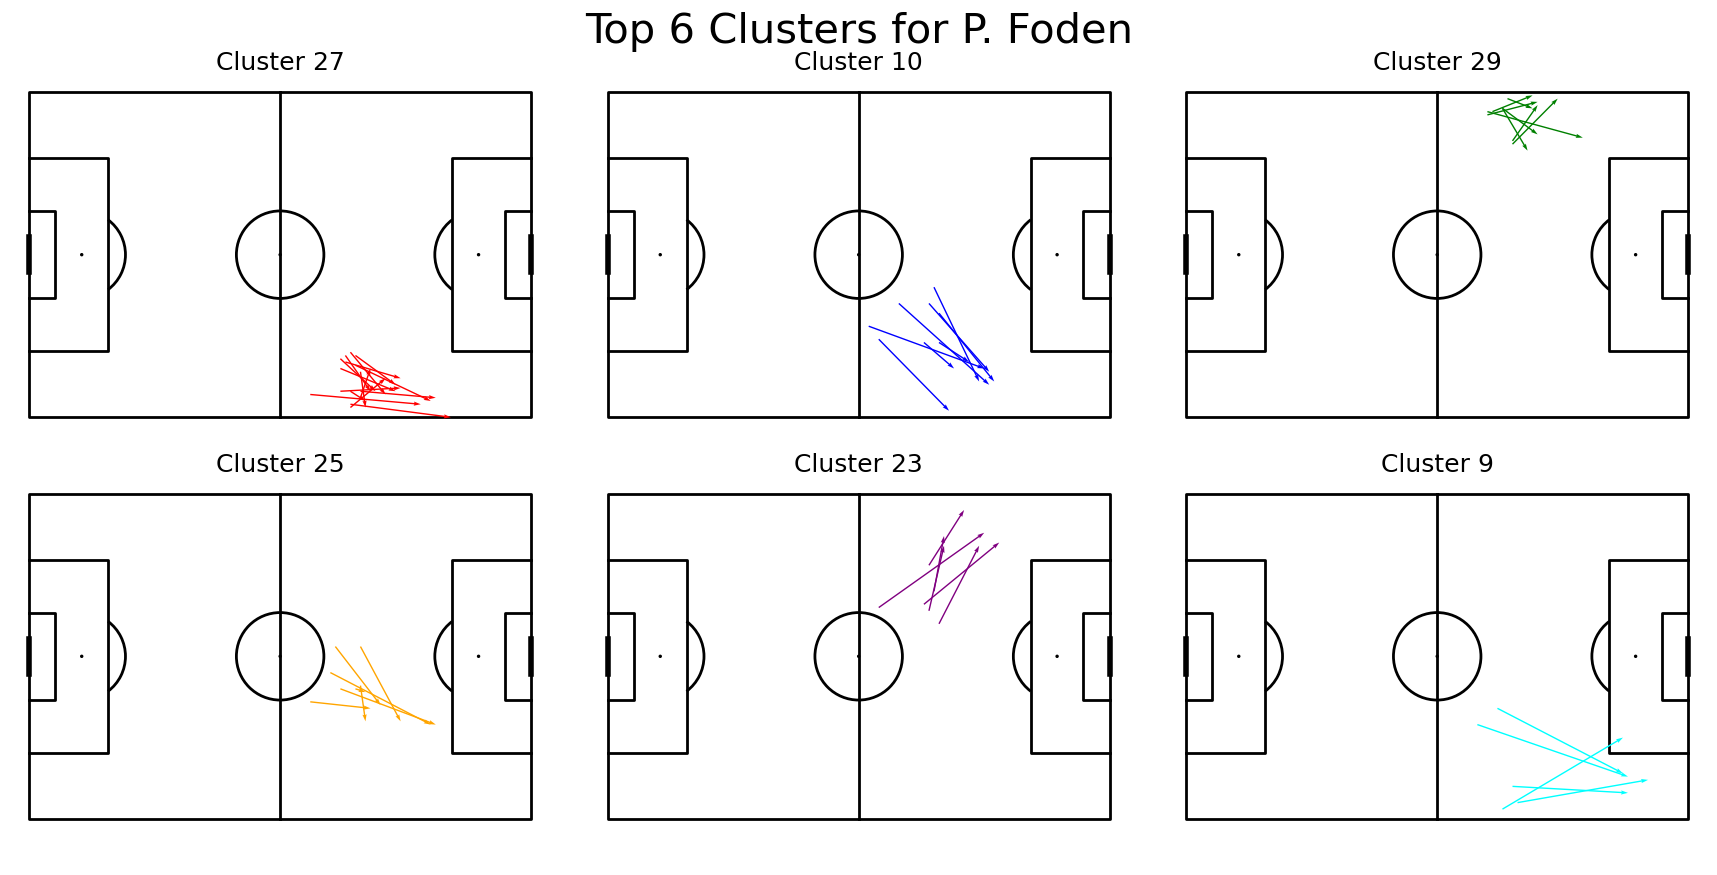

In [90]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for P. Foden', ha='center', va='center', fontsize=30)
plt.show()

### Bočni igralci (centralni)

#### Kyle Walker

In [91]:
row = df_players[df_players['short_name'] == 'K. Walker']
row

player_id short_name birth_date   foot      role passport  \
127       8277  K. Walker 1990-05-28  right  Defender  England   

     __index_level_0__  
127                127

In [92]:
walker_passes = city_passes[city_passes["player_id"] == 8277]
walker_passes.shape

(302, 18)

In [93]:
top_6_clusters = walker_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = walker_passes[walker_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(232, 18)

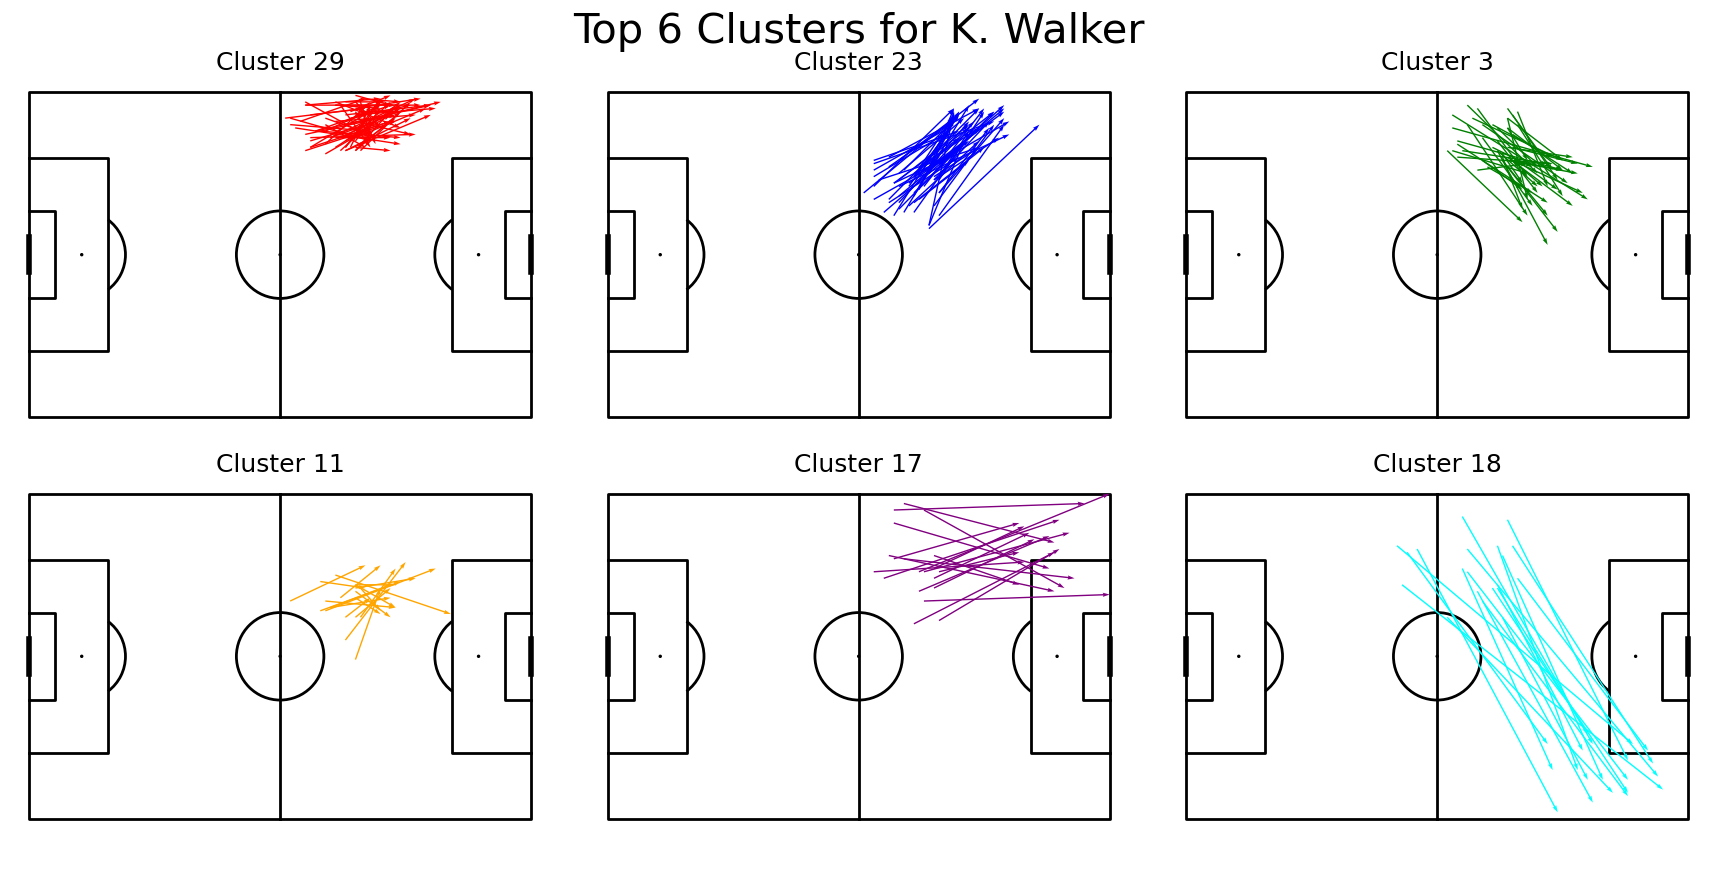

In [95]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for K. Walker', ha='center', va='center', fontsize=30)
plt.show()

#### Joško Gvardiol

In [96]:
row = df_players[df_players['short_name'] == 'J. Gvardiol']
row

player_id   short_name birth_date  foot      role passport  \
494     568412  J. Gvardiol 2002-01-23  left  Defender  Croatia   

     __index_level_0__  
494                494

In [97]:
gvardiol_passes = city_passes[city_passes["player_id"] == 568412]
gvardiol_passes.shape

(71, 18)

In [98]:
top_6_clusters = gvardiol_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = gvardiol_passes[gvardiol_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(59, 18)

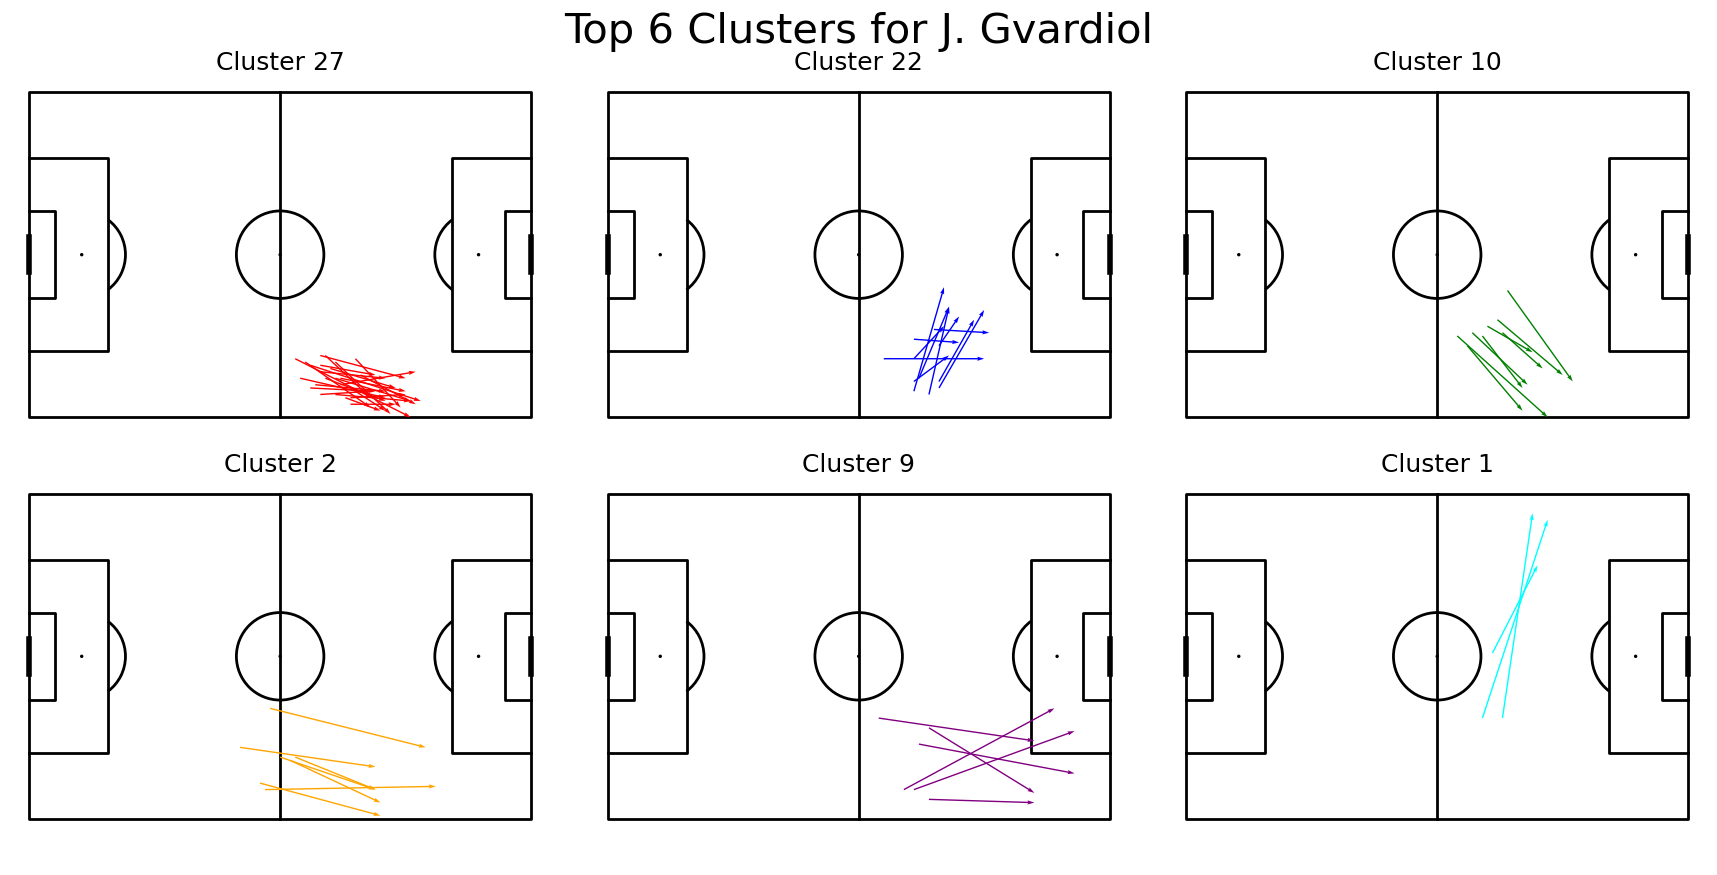

In [99]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for J. Gvardiol', ha='center', va='center', fontsize=30)
plt.show()

#### Manuel Akanji

In [100]:
row = df_players[df_players['short_name'] == 'M. Akanji']
row

player_id short_name birth_date   foot      role passport  \
731     297957  M. Akanji 1995-07-19  right  Defender  Nigeria   

     __index_level_0__  
731                731

In [101]:
akanji_passes = city_passes[city_passes["player_id"] == 297957]
akanji_passes.shape

(210, 18)

In [102]:
top_6_clusters = akanji_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = akanji_passes[akanji_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(125, 18)

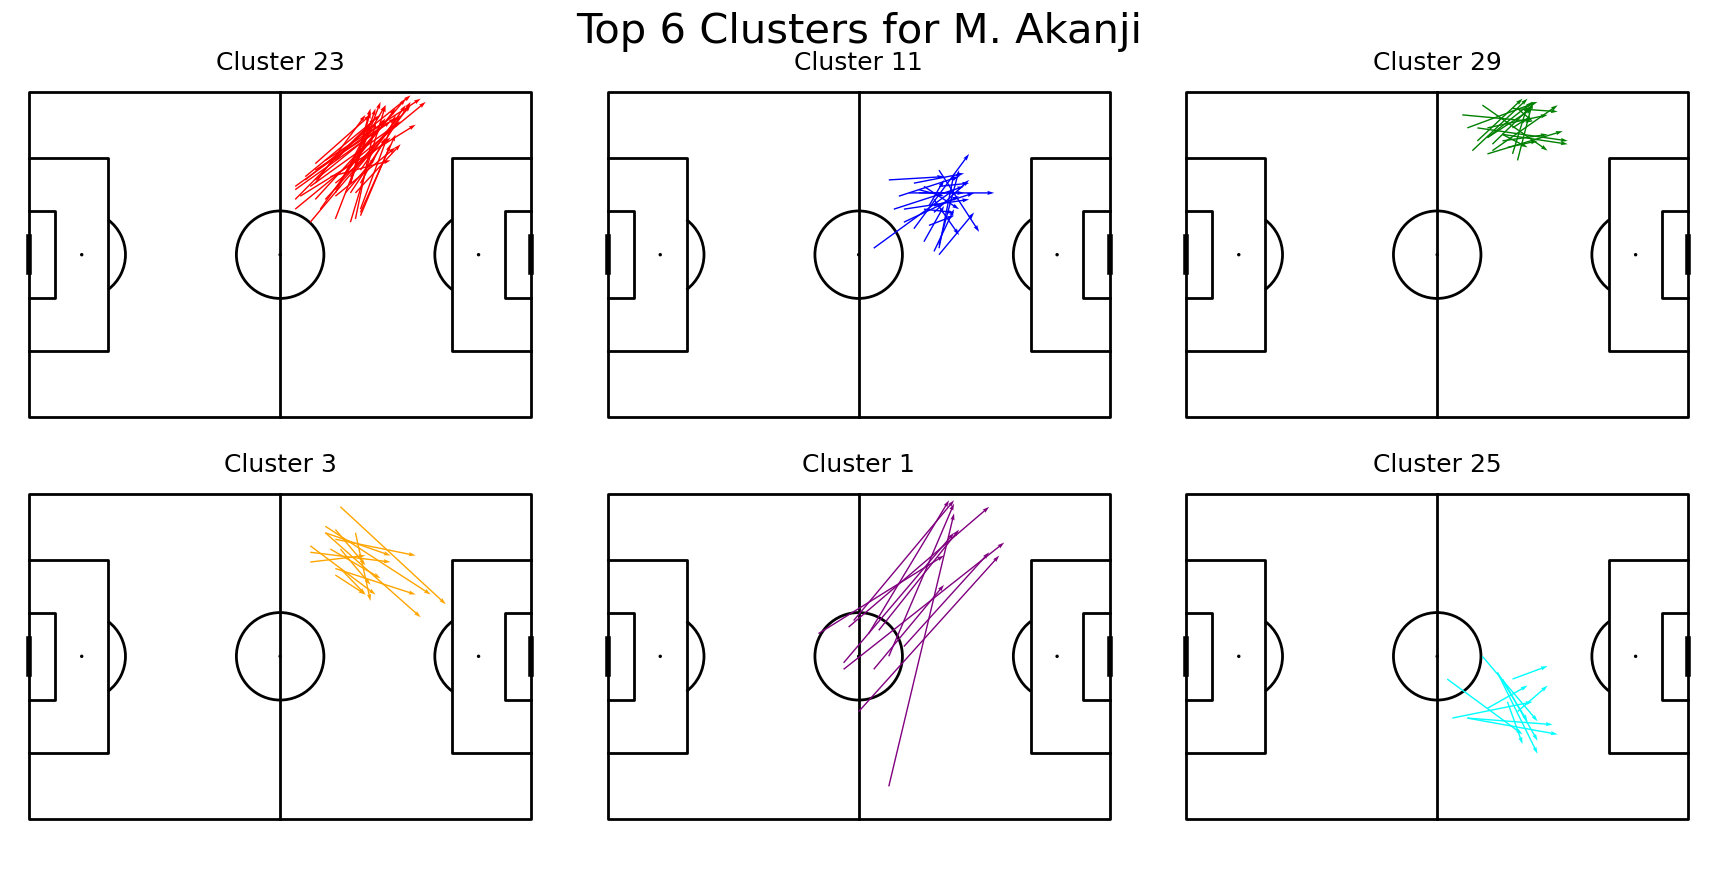

In [103]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for M. Akanji', ha='center', va='center', fontsize=30)
plt.show()

### Centralni branilec

#### Rúben Dias

In [104]:
row = df_players[df_players['short_name'] == 'Rúben Dias']
row

player_id  short_name birth_date   foot      role  passport  \
604     258154  Rúben Dias 1997-05-14  right  Defender  Portugal   

     __index_level_0__  
604                604

In [105]:
dias_passes = city_passes[city_passes["player_id"] == 258154]
dias_passes.shape

(335, 18)

In [106]:
top_6_clusters = dias_passes["label"].value_counts().head(6).index
# Filter rows for the top 6 clusters
top_6_passes = dias_passes[dias_passes["label"].isin(top_6_clusters)]
top_6_passes.shape

(182, 18)

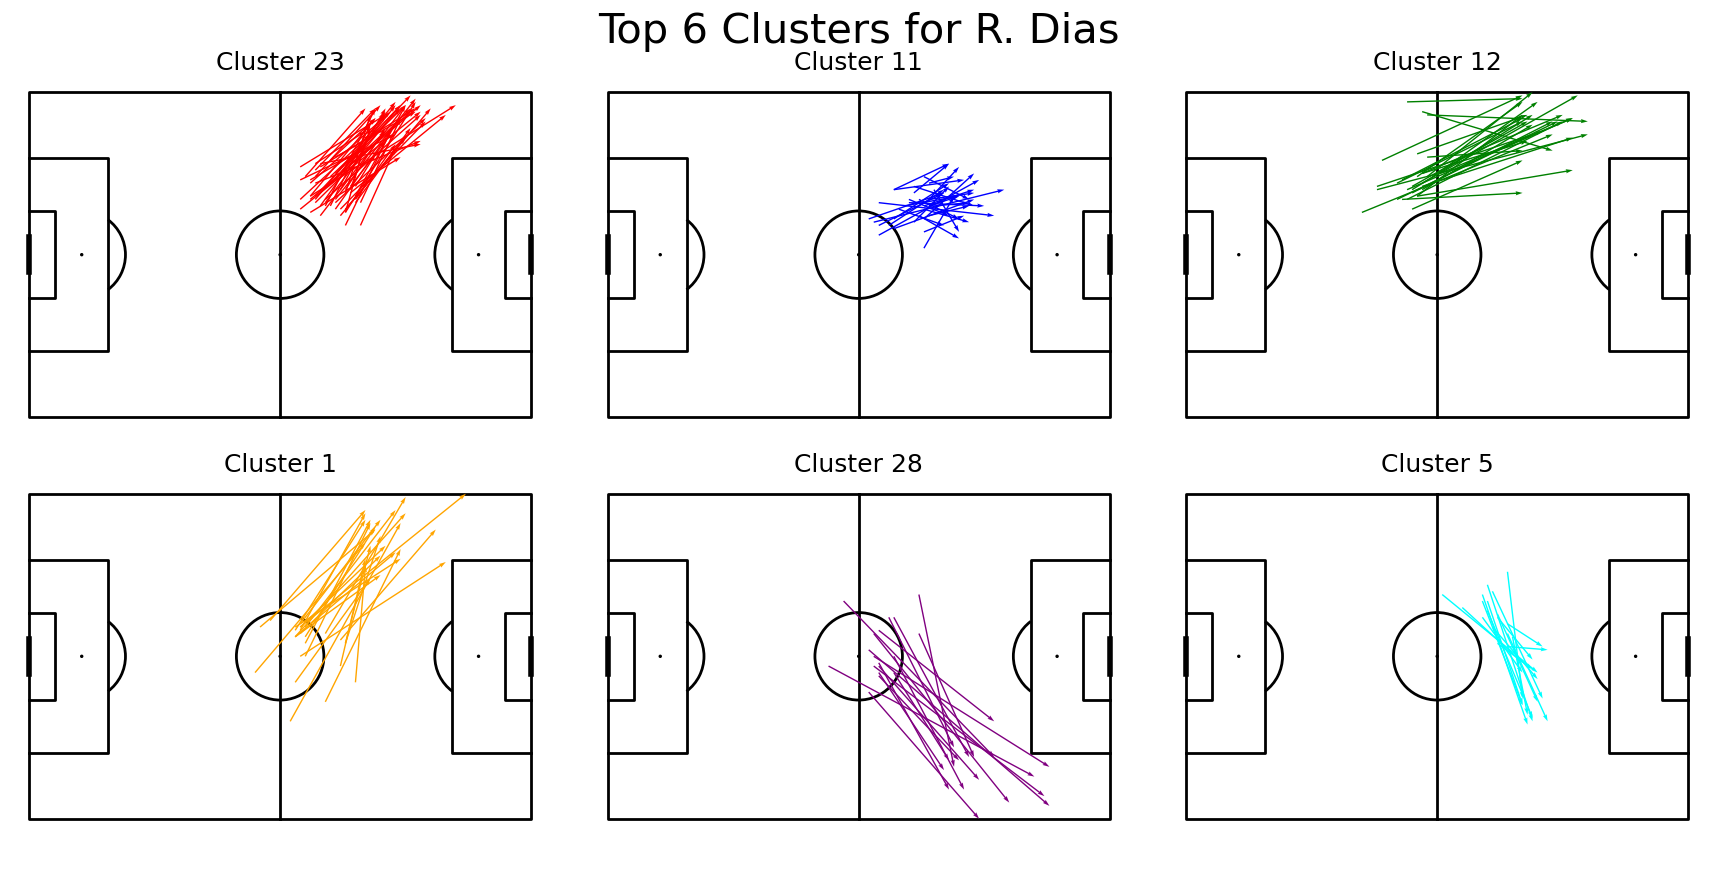

In [107]:
# Assign colors to clusters
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
cluster_color_mapping = {label: color for label, color in zip(top_6_clusters, colors)}

# Set up the pitch grid
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=3, nrows=2, grid_width=0.95, grid_height=0.85, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for cluster, ax in zip(top_6_clusters, axs['pitch'].flat):
    clustered_passes = top_6_passes[top_6_passes["label"] == cluster]
    color = cluster_color_mapping[cluster]
    
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {cluster+1}", ha='center', va='center', fontsize=18)
    
    # Plot passes for the cluster
    pitch.arrows(
        clustered_passes["start_x"], clustered_passes["start_y"],
        clustered_passes["end_x"], clustered_passes["end_y"],
        color=color, ax=ax, width=1
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Top 6 Clusters for R. Dias', ha='center', va='center', fontsize=30)
plt.show()

### Kdo najpogosteje prijema podaje v medprostore
Iz spodnje kode je moč razbrati, da žogo v pol levem in pol desnem medprostoru, v višjem delu napadalne tretine, zdaleč najpogosteje prejemata Kevin De Bruyne in Phil Foden. S podajami v obe coni močno prevladuje Rodri (zadnji vezni), sledijo mu štoperji (Laporte - ki ni več član ekipe, Dias, Akanji). To je še en pokazatelj več kako pomemben je Rodri za igro Man Cityja.

#### Gruča 25

In [131]:
# Filter rows where label is 25 or 11
filtered_passes = city_passes[city_passes['label']==25-1]

# Count occurrences of each pass_recipient_id
most_common_recipients = filtered_passes['pass_recipient_id'].value_counts()

# Output the most common pass_recipient_id(s)
print(most_common_recipients)

pass_recipient_id
 447205    23
 38021     21
 14808     18
-1         17
 364860    16
 550459    10
 11051      9
 135903     8
 427097     7
 265673     6
 11066      5
 134502     5
 568412     4
 658798     4
 134102     3
 69404      3
 589103     2
 241564     2
 9380       1
 26150      1
 340386     1
 297957     1
 549485     1
 359934     1
 551497     1
Name: count, dtype: int64


In [112]:
row = df_players[df_players['player_id'] == 447205]
row

player_id short_name birth_date  foot        role passport  \
142     447205   P. Foden 2000-05-28  left  Midfielder  England   

     __index_level_0__  
142                142

In [111]:
row = df_players[df_players['player_id'] == 38021]
row

player_id    short_name birth_date   foot        role passport  \
596      38021  K. De Bruyne 1991-06-28  right  Midfielder  Belgium   

     __index_level_0__  
596                596

In [132]:
row = df_players[df_players['player_id'] == 14808]
row

player_id   short_name birth_date   foot        role passport  \
359      14808  İ. Gündoğan 1990-10-24  right  Midfielder  Germany   

     __index_level_0__  
359                359

In [133]:
row = df_players[df_players['player_id'] == 364860]
row

player_id short_name birth_date   foot        role passport  \
139     364860      Rodri 1996-06-22  right  Midfielder    Spain   

     __index_level_0__  
139                139

#### Gruča 11

In [134]:
# Filter rows where label is 25 or 11
filtered_passes = city_passes[city_passes['label']==11-1]

# Count occurrences of each pass_recipient_id
most_common_recipients = filtered_passes['pass_recipient_id'].value_counts()

# Output the most common pass_recipient_id(s)
print(most_common_recipients)

pass_recipient_id
 38021     25
 447205    24
 550459    22
-1         21
 265673    14
 14808     14
 26150     14
 364860    13
 427097     9
 9380       7
 135903     7
 8277       6
 658798     6
 11051      5
 11066      5
 589103     5
 69404      5
 340386     4
 297957     3
 551497     2
 258154     1
 397303     1
 134102     1
Name: count, dtype: int64


In [135]:
row = df_players[df_players['player_id'] == 38021]
row

player_id    short_name birth_date   foot        role passport  \
596      38021  K. De Bruyne 1991-06-28  right  Midfielder  Belgium   

     __index_level_0__  
596                596

In [136]:
row = df_players[df_players['player_id'] == 447205]
row

player_id short_name birth_date  foot        role passport  \
142     447205   P. Foden 2000-05-28  left  Midfielder  England   

     __index_level_0__  
142                142

In [137]:
row = df_players[df_players['player_id'] == 550459]
row

player_id  short_name birth_date   foot     role   passport  \
495     550459  J. Álvarez 2000-01-31  right  Forward  Argentina   

     __index_level_0__  
495                495

In [138]:
row = df_players[df_players['player_id'] == 265673]
row

player_id      short_name birth_date  foot        role  passport  \
848     265673  Bernardo Silva 1994-08-10  left  Midfielder  Portugal   

     __index_level_0__  
848                848

### Kdo najpogosteje podaja v medprostore
**Opomba:**
most_common_recepients v tem delu pomeni most_common_passers, zaradi hitrejšega dela in kopiranja kode sem pozabil smiselno preimenovati variablo.

#### Gruča 25

In [121]:
filtered_passes = city_passes[city_passes['label']==25-1]
print(filtered_passes.shape)
# Count occurrences of each pass_recipient_id
most_common_recipients = filtered_passes['player_id'].value_counts()

# Output the most common pass_recipient_id(s)
print(most_common_recipients)

(170, 18)
player_id
364860    41
134502    23
38021     13
258154    13
297957    12
14808     11
134102     8
447205     7
9380       6
265673     6
550459     5
69404      5
105339     3
427097     2
568412     2
11051      2
135903     2
589103     2
549485     2
11066      1
658798     1
241564     1
472696     1
26150      1
Name: count, dtype: int64


In [116]:
row = df_players[df_players['player_id'] == 364860]
row

player_id short_name birth_date   foot        role passport  \
139     364860      Rodri 1996-06-22  right  Midfielder    Spain   

     __index_level_0__  
139                139

In [122]:
row = df_players[df_players['player_id'] == 134502]
row

player_id       short_name birth_date  foot      role passport  \
5     134502  Aymeric Laporte 1994-05-27  left  Defender    Spain   

   __index_level_0__  
5                  5

In [123]:
row = df_players[df_players['player_id'] == 38021]
row

player_id    short_name birth_date   foot        role passport  \
596      38021  K. De Bruyne 1991-06-28  right  Midfielder  Belgium   

     __index_level_0__  
596                596

In [114]:
row = df_players[df_players['player_id'] == 258154]
row

player_id  short_name birth_date   foot      role  passport  \
604     258154  Rúben Dias 1997-05-14  right  Defender  Portugal   

     __index_level_0__  
604                604

In [124]:
row = df_players[df_players['player_id'] == 297957]
row

player_id short_name birth_date   foot      role passport  \
731     297957  M. Akanji 1995-07-19  right  Defender  Nigeria   

     __index_level_0__  
731                731

#### Gruča 11

In [125]:
filtered_passes = city_passes[city_passes['label']==11-1]
print(filtered_passes.shape)
# Count occurrences of each pass_recipient_id
most_common_recipient = filtered_passes['player_id'].value_counts()

# Output the most common pass_recipient_id(s)
print(most_common_recipients)

(214, 18)
player_id
364860    52
258154    32
297957    25
8277      20
9380      11
14808      9
265673     9
38021      8
69404      7
105339     7
550459     5
359934     5
26150      4
134102     4
447205     3
658798     3
135903     3
568412     2
427097     2
11051      1
134502     1
340386     1
Name: count, dtype: int64


In [126]:
row = df_players[df_players['player_id'] == 364860]
row

player_id short_name birth_date   foot        role passport  \
139     364860      Rodri 1996-06-22  right  Midfielder    Spain   

     __index_level_0__  
139                139

In [127]:
row = df_players[df_players['player_id'] == 258154]
row

player_id  short_name birth_date   foot      role  passport  \
604     258154  Rúben Dias 1997-05-14  right  Defender  Portugal   

     __index_level_0__  
604                604

In [128]:
row = df_players[df_players['player_id'] == 297957]
row

player_id short_name birth_date   foot      role passport  \
731     297957  M. Akanji 1995-07-19  right  Defender  Nigeria   

     __index_level_0__  
731                731

In [129]:
row = df_players[df_players['player_id'] == 8277]
row

player_id short_name birth_date   foot      role passport  \
127       8277  K. Walker 1990-05-28  right  Defender  England   

     __index_level_0__  
127                127

In [130]:
row = df_players[df_players['player_id'] == 9380]
row

player_id short_name birth_date   foot      role passport  \
478       9380  J. Stones 1994-05-28  right  Defender  England   

     __index_level_0__  
478                478

### Komu najpogosteje podajata De Bruyne in Foden?
Iz spodnje kode je razvidno, da si največ podaj med seboj izmenjajo prav trije vezni igralci (De Bruyne, Foden, Silva), hkrati pa oba pogosto igrata s krilnim igralcem, preko katerih city poiskuša ustvarjati višek.

#### Kevin De Bruyne

In [140]:
deBruyne_passes = city_passes[city_passes["player_id"] == 38021]
deBruyne_passes.shape

(181, 18)

In [142]:
most_common_recipient = deBruyne_passes['pass_recipient_id'].value_counts()
most_common_recipient

pass_recipient_id
 447205    31
-1         28
 265673    17
 11051     17
 26150     16
 11066     14
 14808      8
 135903     7
 427097     7
 550459     6
 364860     4
 8277       4
 340386     3
 9380       3
 658798     2
 589103     2
 472696     2
 551497     2
 241564     2
 297957     1
 134102     1
 69404      1
 38021      1
 258154     1
 549485     1
Name: count, dtype: int64

In [143]:
row = df_players[df_players['player_id'] == 447205]
row

player_id short_name birth_date  foot        role passport  \
142     447205   P. Foden 2000-05-28  left  Midfielder  England   

     __index_level_0__  
142                142

In [144]:
row = df_players[df_players['player_id'] == 265673]
row

player_id      short_name birth_date  foot        role  passport  \
848     265673  Bernardo Silva 1994-08-10  left  Midfielder  Portugal   

     __index_level_0__  
848                848

In [145]:
row = df_players[df_players['player_id'] == 11051]
row

player_id   short_name birth_date   foot     role          passport  \
620      11051  J. Grealish 1995-09-10  right  Forward  Ireland Republic   

     __index_level_0__  
620                620

In [146]:
row = df_players[df_players['player_id'] == 26150]
row

player_id short_name birth_date  foot     role passport  \
841      26150  R. Mahrez 1991-02-21  left  Forward  Algeria   

     __index_level_0__  
841                841

In [147]:
row = df_players[df_players['player_id'] == 11066]
row

player_id   short_name birth_date   foot     role passport  \
133      11066  R. Sterling 1994-12-08  right  Forward  England   

     __index_level_0__  
133                133

#### Phil Foden

In [149]:
foden_passes = city_passes[city_passes["player_id"] == 447205]
foden_passes.shape

(100, 18)

In [150]:
most_common_recipient = foden_passes['pass_recipient_id'].value_counts()
most_common_recipient

pass_recipient_id
-1         25
 549485    10
 38021     10
 550459     6
 135903     6
 265673     6
 11051      5
 11066      5
 364860     5
 26150      5
 551497     4
 427097     3
 568412     2
 340386     2
 658798     2
 8277       2
 14808      1
 69404      1
Name: count, dtype: int64

In [151]:
row = df_players[df_players['player_id'] == 549485]
row

player_id short_name birth_date   foot     role passport  \
736     549485    J. Doku 2002-05-27  right  Forward    Ghana   

     __index_level_0__  
736                736

In [152]:
row = df_players[df_players['player_id'] == 38021]
row

player_id    short_name birth_date   foot        role passport  \
596      38021  K. De Bruyne 1991-06-28  right  Midfielder  Belgium   

     __index_level_0__  
596                596

In [153]:
row = df_players[df_players['player_id'] == 550459]
row

player_id  short_name birth_date   foot     role   passport  \
495     550459  J. Álvarez 2000-01-31  right  Forward  Argentina   

     __index_level_0__  
495                495

In [154]:
row = df_players[df_players['player_id'] == 135903]
row

player_id    short_name birth_date   foot      role  passport  \
244     135903  João Cancelo 1994-05-27  right  Defender  Portugal   

     __index_level_0__  
244                244

In [155]:
row = df_players[df_players['player_id'] == 265673]
row

player_id      short_name birth_date  foot        role  passport  \
848     265673  Bernardo Silva 1994-08-10  left  Midfielder  Portugal   

     __index_level_0__  
848                848

### Podaje na Haalanda
Še en dodatni pokazatelj, zakaj je Rodri tako pomemben za ekipo cityja, namreč največ odigranih podaj na haalanda ima prav on. S temi podajami (DCM -> ST) uspe City preskočiti celotno ali pa večino vezne linije nasprotnika.

In [156]:
row = df_players[df_players['short_name'] == 'E. Haaland']
row

player_id  short_name birth_date  foot     role passport  \
389     427097  E. Haaland 2000-07-21  left  Forward   Norway   

     __index_level_0__  
389                389

In [157]:
pas_na_haalanda = city_passes[city_passes["pass_recipient_id"] == 427097]
pas_na_haalanda.shape

(77, 18)

In [158]:
# Count occurrences of each pass_recipient_id
most_common_passers = pas_na_haalanda['player_id'].value_counts()

# Output the most common pass_recipient_id(s)
print(most_common_passers)

player_id
364860    13
71654      8
38021      7
258154     7
14808      5
8277       5
297957     4
134102     4
550459     4
265673     4
447205     3
69404      3
15146      2
658798     2
11051      1
26150      1
549485     1
0          1
134502     1
568412     1
Name: count, dtype: int64


In [159]:
row = df_players[df_players['player_id'] == 364860]
row

player_id short_name birth_date   foot        role passport  \
139     364860      Rodri 1996-06-22  right  Midfielder    Spain   

     __index_level_0__  
139                139

In [160]:
row = df_players[df_players['player_id'] == 71654]
row

player_id short_name birth_date  foot        role  passport  \
6      71654    Ederson 1993-08-17  left  Goalkeeper  Portugal   

   __index_level_0__  
6                  6

In [161]:
row = df_players[df_players['player_id'] == 38021]
row

player_id    short_name birth_date   foot        role passport  \
596      38021  K. De Bruyne 1991-06-28  right  Midfielder  Belgium   

     __index_level_0__  
596                596

In [162]:
row = df_players[df_players['player_id'] == 258154]
row

player_id  short_name birth_date   foot      role  passport  \
604     258154  Rúben Dias 1997-05-14  right  Defender  Portugal   

     __index_level_0__  
604                604

### Kako City podaja v najnevarnejšo cono glede na Goal 2D histogram?
**Glede na Goal 2D histogram iz xT_city.ipynb je najnevarnejša cona da City doseže gol cona 26X23 pred nasprotnikovim golom**

Zanimajo me podaje, ki so se zgodile v napadalni coni in imajo začetek izven najnevarnejše cone.

In [24]:
city_passes = duckdb.sql(f"""
    SELECT * FROM 'data/stories.parquet'
    WHERE team_id = 1625 AND type = 'pass'
""").df()

city_passes.head(3)

player_position  throw_in  start_x  penalty_conceded_goal  penalty_foul  \
0           LCMF3     False       50                  False         False   
1              GK     False       23                  False         False   
2              LB     False       41                  False         False   

   lateral_pass  own_goal  linkup_play  type  red_card  ...  shot_goal_zone  \
0         False     False        False  pass     False  ...            None   
1         False     False        False  pass     False  ...            None   
2         False     False        False  pass     False  ...            None   

   conceded_goal  is_pass  possession_attack  pass_blocked  opportunity  \
0          False     True              False         False        False   
1          False     True              False         False        False   
2          False     True              False         False        False   

   possession_id  shot_id  possession_set_piece_attack  __index_level_0__  
0     1298869671        0                        False              13077  
1     1298869671        0                        False              13079  
2     1298869671        0                        False              13080  

[3 rows x 138 columns]

In [12]:
city_passes.shape

(73839, 138)

In [25]:
# Create a copy and scale the coordinates to real pitch dimensions (105x68 meters)
df_dangerous = city_passes.copy()
df_dangerous["start_x"] *= 105 / 100
df_dangerous["start_y"] *= 68 / 100
df_dangerous["end_x"] *= 105 / 100
df_dangerous["end_y"] *= 68 / 100

df_dangerous.head(3)

player_position  throw_in  start_x  penalty_conceded_goal  penalty_foul  \
0           LCMF3     False    52.50                  False         False   
1              GK     False    24.15                  False         False   
2              LB     False    43.05                  False         False   

   lateral_pass  own_goal  linkup_play  type  red_card  ...  shot_goal_zone  \
0         False     False        False  pass     False  ...            None   
1         False     False        False  pass     False  ...            None   
2         False     False        False  pass     False  ...            None   

   conceded_goal  is_pass  possession_attack  pass_blocked  opportunity  \
0          False     True              False         False        False   
1          False     True              False         False        False   
2          False     True              False         False        False   

   possession_id  shot_id  possession_set_piece_attack  __index_level_0__  
0     1298869671        0                        False              13077  
1     1298869671        0                        False              13079  
2     1298869671        0                        False              13080  

[3 rows x 138 columns]

In [26]:
df_dangerous.shape

(73839, 138)

In [40]:
dangerous_zone_passes = df_dangerous[
    (df_dangerous['end_y'] >= 22) & (df_dangerous['end_y'] <= 46) & ((df_dangerous['start_y'] < 22) | (df_dangerous['start_y'] > 46)) & (df_dangerous['end_x'] > 79) & (df_dangerous['start_x'] > 70)
]

dangerous_zone_passes.head(3)

player_position  throw_in  start_x  penalty_conceded_goal  penalty_foul  \
114             RWF     False   101.85                  False         False   
153           RCMF3     False    75.60                  False         False   
159              LB     False    75.60                  False         False   

     lateral_pass  own_goal  linkup_play  type  red_card  ...  shot_goal_zone  \
114          True     False        False  pass     False  ...            None   
153         False     False        False  pass     False  ...            None   
159          True     False        False  pass     False  ...            None   

     conceded_goal  is_pass  possession_attack  pass_blocked  opportunity  \
114          False     True               True         False        False   
153          False     True               True         False        False   
159          False     True               True         False        False   

     possession_id  shot_id  possession_set_piece_attack  __index_level_0__  
114     1298869902        0                        False              13362  
153     1298869984        0                        False              13430  
159     1298870016        0                        False              13444  

[3 rows x 138 columns]

In [41]:
dangerous_zone_passes.shape

(2670, 138)

In [73]:
df_players = duckdb.sql(f"""SELECT * FROM 'data/players.parquet' """).df()
df_players.shape

(940, 7)

In [31]:
df_players.head(1)

player_id short_name birth_date   foot        role passport  \
0       8319  J. Milner 1986-01-04  right  Midfielder  England   

   __index_level_0__  
0                  0

In [42]:
dangerous_zone_passes = dangerous_zone_passes.merge(df_players[['player_id', 'role']], 
                                                    left_on='player_id', 
                                                    right_on='player_id', 
                                                    how='left')

In [43]:
# Filter into successful and unsuccessful passes
successful_passes = dangerous_zone_passes[dangerous_zone_passes['successful']]
unsuccessful_passes = dangerous_zone_passes[~dangerous_zone_passes['successful']]

In [44]:
most_common_roles = successful_passes['role'].value_counts()

print(most_common_roles)

role
Midfielder    641
Forward       461
Defender      286
Name: count, dtype: int64


In [45]:
most_common_roles_un = unsuccessful_passes['role'].value_counts()

print(most_common_roles_un)

role
Midfielder    596
Defender      346
Forward       340
Name: count, dtype: int64


C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_22532\923765038.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_passes['color'] = successful_passes['role'].map(role_colors)


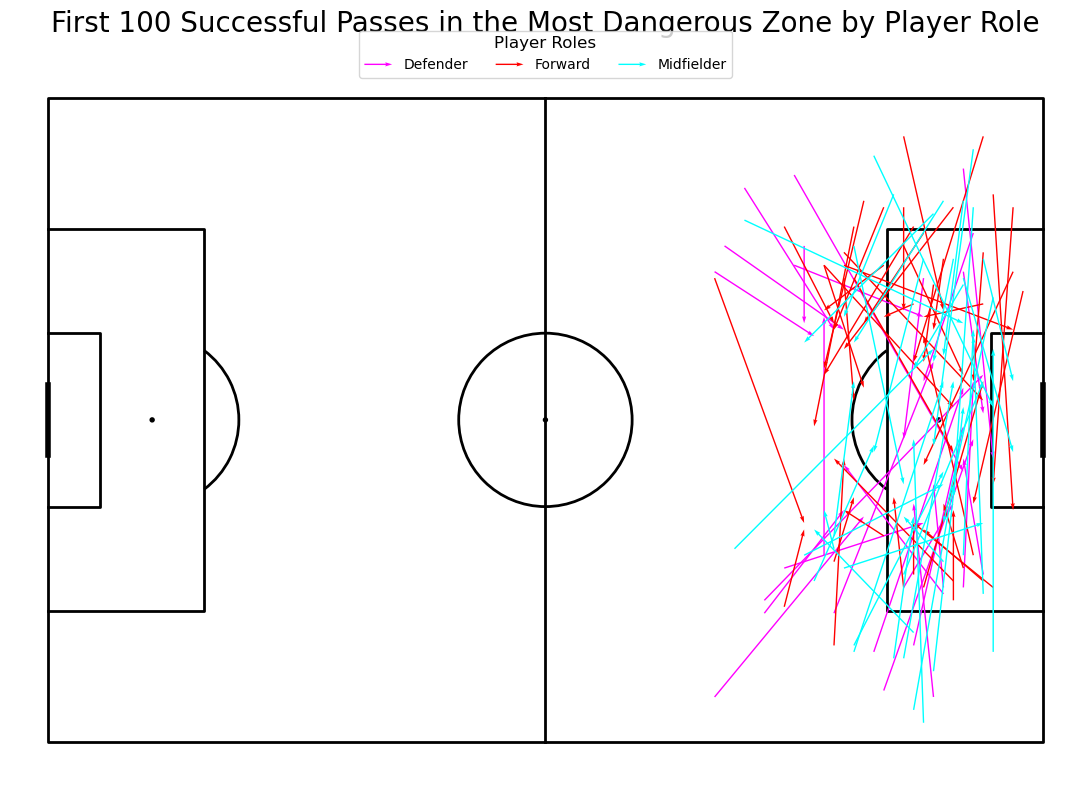

In [46]:
# Define color mapping for roles
role_colors = {
    'Goalkeeper': 'green',
    'Defender': 'magenta',
    'Midfielder': 'cyan',
    'Forward': 'red'
}

# Assign colors to passes based on role
successful_passes['color'] = successful_passes['role'].map(role_colors)

# Limit the plotting to the first 100 passes
limited_passes = successful_passes.head(100)  # Select the first 100 rows

# Set up the pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(12, 8))

# Plot the passes for each role
for role, group in limited_passes.groupby('role'):
    color = role_colors.get(role, 'gray')  # Default color if role is missing
    pitch.arrows(
        group['start_x'], group['start_y'],
        group['end_x'], group['end_y'],
        color=color, ax=ax, width=1, label=role
    )

# Add legend
legend = ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, 
    fontsize=10, frameon=True, title="Player Roles", title_fontsize=12
)

# Set the title
ax.set_title('First 100 Successful Passes in the Most Dangerous Zone by Player Role', fontsize=20, pad=20)

plt.show()

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_22532\2670193351.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsuccessful_passes['color'] = unsuccessful_passes['role'].map(role_colors)


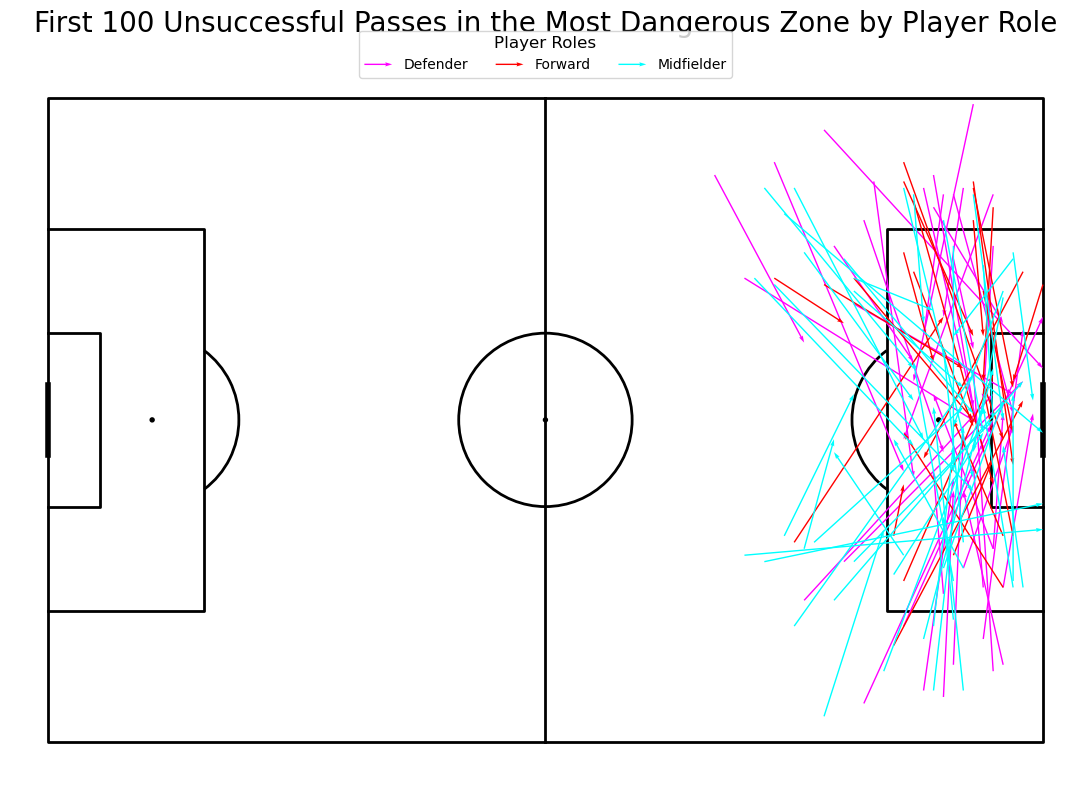

In [48]:
# Define color mapping for roles
role_colors = {
    'Goalkeeper': 'green',
    'Defender': 'magenta',
    'Midfielder': 'cyan',
    'Forward': 'red'
}

# Assign colors to passes based on role
unsuccessful_passes['color'] = unsuccessful_passes['role'].map(role_colors)

# Limit the plotting to the first 100 passes
limited_passes = unsuccessful_passes.head(100)  # Select the first 100 rows

# Set up the pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(12, 8))

# Plot the passes for each role
for role, group in limited_passes.groupby('role'):
    color = role_colors.get(role, 'gray')  # Default color if role is missing
    pitch.arrows(
        group['start_x'], group['start_y'],
        group['end_x'], group['end_y'],
        color=color, ax=ax, width=1, label=role
    )

# Add legend
legend = ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, 
    fontsize=10, frameon=True, title="Player Roles", title_fontsize=12
)

# Set the title
ax.set_title('First 100 Unsuccessful Passes in the Most Dangerous Zone by Player Role', fontsize=20, pad=20)

plt.show()

### Od kje prihaja največ assistov, second assistov in third assistov?

In [49]:
city_passes = duckdb.sql(f"""
    SELECT * FROM 'data/stories.parquet'
    WHERE team_id = 1625 AND type = 'pass'
""").df()

city_passes.head(3)

player_position  throw_in  start_x  penalty_conceded_goal  penalty_foul  \
0           LCMF3     False       50                  False         False   
1              GK     False       23                  False         False   
2              LB     False       41                  False         False   

   lateral_pass  own_goal  linkup_play  type  red_card  ...  shot_goal_zone  \
0         False     False        False  pass     False  ...            None   
1         False     False        False  pass     False  ...            None   
2         False     False        False  pass     False  ...            None   

   conceded_goal  is_pass  possession_attack  pass_blocked  opportunity  \
0          False     True              False         False        False   
1          False     True              False         False        False   
2          False     True              False         False        False   

   possession_id  shot_id  possession_set_piece_attack  __index_level_0__  
0     1298869671        0                        False              13077  
1     1298869671        0                        False              13079  
2     1298869671        0                        False              13080  

[3 rows x 138 columns]

In [50]:
# Create a copy and scale the coordinates to real pitch dimensions (105x68 meters)
df_copy = city_passes.copy()
df_copy["start_x"] *= 105 / 100
df_copy["start_y"] *= 68 / 100
df_copy["end_x"] *= 105 / 100
df_copy["end_y"] *= 68 / 100

df_copy.head(3)

player_position  throw_in  start_x  penalty_conceded_goal  penalty_foul  \
0           LCMF3     False    52.50                  False         False   
1              GK     False    24.15                  False         False   
2              LB     False    43.05                  False         False   

   lateral_pass  own_goal  linkup_play  type  red_card  ...  shot_goal_zone  \
0         False     False        False  pass     False  ...            None   
1         False     False        False  pass     False  ...            None   
2         False     False        False  pass     False  ...            None   

   conceded_goal  is_pass  possession_attack  pass_blocked  opportunity  \
0          False     True              False         False        False   
1          False     True              False         False        False   
2          False     True              False         False        False   

   possession_id  shot_id  possession_set_piece_attack  __index_level_0__  
0     1298869671        0                        False              13077  
1     1298869671        0                        False              13079  
2     1298869671        0                        False              13080  

[3 rows x 138 columns]

In [51]:
assists_only = df_copy[df_copy['assist']]
assists_only.shape

(149, 138)

In [52]:
sec_assists_only = df_copy[df_copy['second_assist']]
sec_assists_only.shape

(76, 138)

In [53]:
thr_assists_only = df_copy[df_copy['third_assist']]
thr_assists_only.shape

(53, 138)

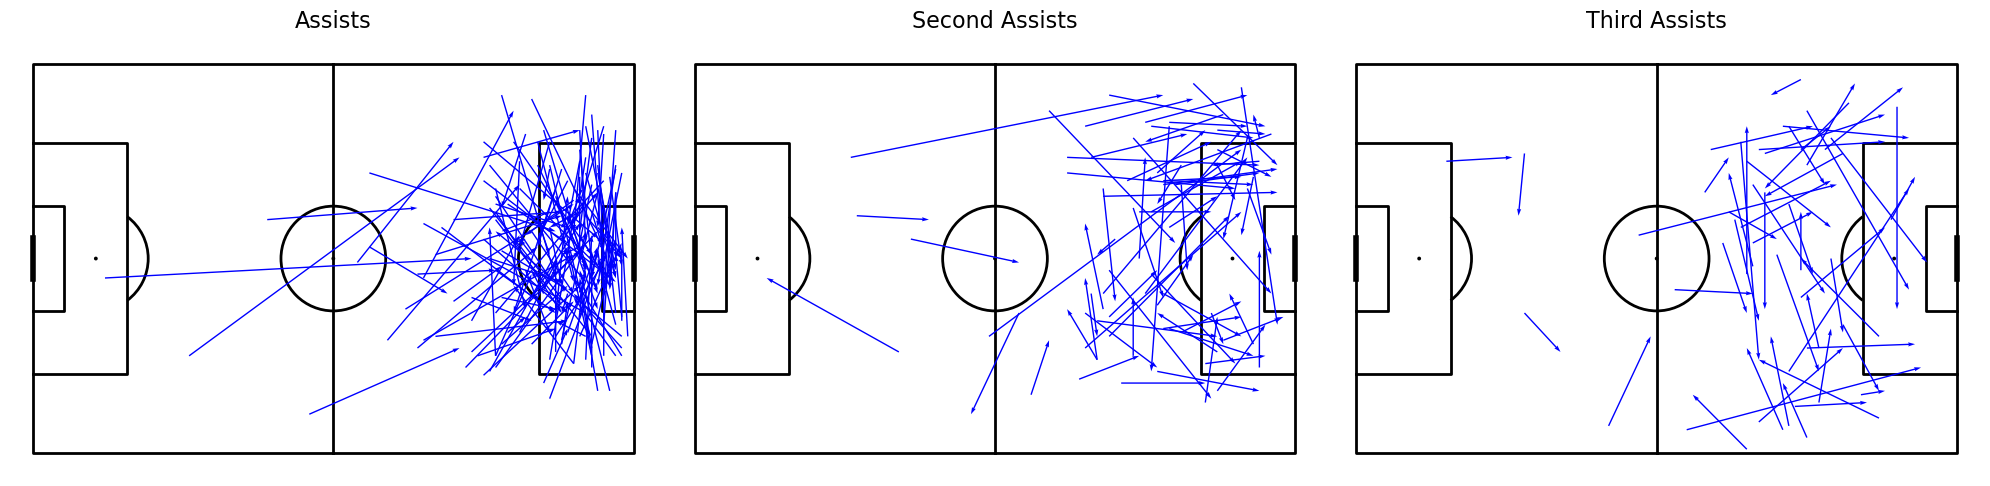

In [54]:
# Set up the pitch dimensions
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)

# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Titles for each subplot
titles = ['Assists', 'Second Assists', 'Third Assists']
datasets = [assists_only, sec_assists_only, thr_assists_only]

# Loop through each dataset and plot it on its respective pitch
for ax, data, title in zip(axes, datasets, titles):
    pitch.draw(ax=ax)
    ax.set_title(title, fontsize=16, pad=10)
    
    # Plot the passes
    pitch.arrows(
        data['start_x'], data['start_y'],
        data['end_x'], data['end_y'],
        color='blue', ax=ax, width=1
    )

# Show the plots
plt.tight_layout()
plt.show()

Vidimo, da največ drugih in tretjih asistenc prihaja prav iz prej omenjenih medprostorov, kjer se gibljeta Foden in De Bruyne, pravtako pa iz teh prostorov pride dosti asistenc.

## Analiza Haalandovih sprejetih podaj

In [55]:
pass_to_haaland = df_copy[df_copy['pass_recipient_id'] == 427097]
pass_to_haaland.shape

(1081, 138)

In [56]:
df_copy = pass_to_haaland.copy()
df_copy["start_x"] *= 105 / 100
df_copy["start_y"] *= 68 / 100
df_copy["end_x"] *= 105 / 100
df_copy["end_y"] *= 68 / 100

df_copy.head(3)

player_position  throw_in  start_x  penalty_conceded_goal  penalty_foul  \
24964            LAMF     False  60.6375                  False         False   
25022              RB     False  22.0500                  False         False   
25028              RB     False  46.3050                  False         False   

       lateral_pass  own_goal  linkup_play  type  red_card  ...  \
24964          True     False        False  pass     False  ...   
25022         False     False        False  pass     False  ...   
25028         False     False        False  pass     False  ...   

       shot_goal_zone  conceded_goal  is_pass  possession_attack  \
24964            None          False     True               True   
25022            None          False     True              False   
25028            None          False     True              False   

       pass_blocked  opportunity  possession_id     shot_id  \
24964         False        False     1423399382  1423399406   
25022         False        False     1423399623           0   
25028         False        False     1423399672           0   

       possession_set_piece_attack  __index_level_0__  
24964                        False             660459  
25022                        False             660633  
25028                        False             660658  

[3 rows x 138 columns]

In [57]:
average_end_x = df_copy["end_x"].mean()
print(f"The average end_x is: {average_end_x}")

The average end_x is: 77.8715841813136


Haaland v povprečju podaje sprejema zelo blizu nasprotnikovim vratom, kar kaže na njegovo neudejstvovanje v izgradnji napada.

### Kako se spreminja število golov v odvisnosti pozicije, kjer napadalec prejema podaje?
Oziroma kako na število zadetkov napadalca vpliva njegova oddaljenost od gola (smer x) ko sprejema podaje?

**Hipoteza**: Bližje nasprotnikovemu golu, kot napadalec sprejema podaje, več zadetkov bo imel.

In [58]:
df_stories = duckdb.sql(f"""SELECT * FROM 'data/stories.parquet' """).df()

In [62]:
filtered_stories = df_stories[(df_stories['goal'] == True) & (df_stories['player_position'] == 'CF')]
filtered_stories.shape

(931, 138)

In [64]:
# Count the occurrences of each player_id
player_counts = filtered_stories['player_id'].value_counts()

# Filter the player_ids that appear at least 10 times
players_with_10_goals = player_counts[player_counts >= 10].index

# Filter the original dataframe to keep only the rows with those player_ids
filtered_stories_10_goals = filtered_stories[filtered_stories['player_id'].isin(players_with_10_goals)]
filtered_stories_10_goals.shape

(668, 138)

In [65]:
unique_player_ids = filtered_stories_10_goals['player_id'].unique()
unique_player_ids.shape

(35,)

In [67]:
unique_player_ids

array([346158,   7945,  11669, 425925,  12829,   8717, 366720, 293687,
        14879,   8677, 301047,   3322, 377071, 340386,   8955, 345621,
       243886,  70129,   9206,  15808, 112392, 397178, 347202,  14911,
       543978, 427097, 128214, 286831, 399599, 285506, 550459, 286368,
       616591, 419213, 669602], dtype=int64)

In [68]:
# Count how many times each of the 35 player_id values appears in filtered_stories
goal_counts = filtered_stories[filtered_stories['player_id'].isin(unique_player_ids)]['player_id'].value_counts()

# Create a new DataFrame with player_id and their goal count
goals_df = goal_counts.reset_index()
goals_df.columns = ['id', 'goals']

# Display the new DataFrame
goals_df.head(3)

id  goals
0  427097     63
1    8717     43
2  301047     38

In [69]:
passes = duckdb.sql(f"""
    SELECT * FROM 'data/stories.parquet'
    WHERE type = 'pass'
""").df()

passes.head(3)

player_position  throw_in  start_x  penalty_conceded_goal  penalty_foul  \
0             AMF     False       49                  False         False   
1              CF     False       27                  False         False   
2             RCB     False       57                  False         False   

   lateral_pass  own_goal  linkup_play  type  red_card  ...  shot_goal_zone  \
0         False     False        False  pass     False  ...            None   
1         False     False        False  pass     False  ...            None   
2         False     False        False  pass     False  ...            None   

   conceded_goal  is_pass  possession_attack  pass_blocked  opportunity  \
0          False     True               True         False        False   
1          False     True               True         False        False   
2          False     True               True         False        False   

   possession_id  shot_id  possession_set_piece_attack  __index_level_0__  
0     1296149340        0                        False                  0  
1     1296149340        0                        False                  1  
2     1296149340        0                        False                  3  

[3 rows x 138 columns]

In [70]:
passes_copy = passes.copy()
passes_copy["start_x"] *= 105 / 100
passes_copy["start_y"] *= 68 / 100
passes_copy["end_x"] *= 105 / 100
passes_copy["end_y"] *= 68 / 100

passes_copy.head(3)

player_position  throw_in  start_x  penalty_conceded_goal  penalty_foul  \
0             AMF     False    51.45                  False         False   
1              CF     False    28.35                  False         False   
2             RCB     False    59.85                  False         False   

   lateral_pass  own_goal  linkup_play  type  red_card  ...  shot_goal_zone  \
0         False     False        False  pass     False  ...            None   
1         False     False        False  pass     False  ...            None   
2         False     False        False  pass     False  ...            None   

   conceded_goal  is_pass  possession_attack  pass_blocked  opportunity  \
0          False     True               True         False        False   
1          False     True               True         False        False   
2          False     True               True         False        False   

   possession_id  shot_id  possession_set_piece_attack  __index_level_0__  
0     1296149340        0                        False                  0  
1     1296149340        0                        False                  1  
2     1296149340        0                        False                  3  

[3 rows x 138 columns]

In [71]:
# Filter passes_copy to include only rows where pass_recipient_id matches ids in goals_df
recipient_passes = passes_copy[passes_copy['pass_recipient_id'].isin(goals_df['id'])]

# Calculate the average of end_x for each pass_recipient_id
average_end_x = recipient_passes.groupby('pass_recipient_id')['end_x'].mean().reset_index()
average_end_x.columns = ['id', 'average_end_x']

# Merge the average end_x values with the goals_df
goals_df = pd.merge(goals_df, average_end_x, on='id', how='left')

# Display the updated goals_df
goals_df

id  goals  average_end_x
0   427097     63      74.163414
1     8717     43      66.323524
2   301047     38      71.294050
3   243886     34      67.721569
4    11669     33      71.770110
5   399599     29      70.865541
6   366720     23      68.938011
7   286831     23      69.195301
8     9206     22      68.334035
9   345621     19      69.214103
10    8677     19      70.773772
11    3322     18      68.791422
12   12829     17      72.480162
13  340386     16      73.053587
14  285506     15      69.033398
15  293687     15      72.449089
16  425925     15      69.816761
17  128214     14      67.461572
18  346158     14      70.172759
19  669602     14      68.117517
20   15808     14      66.965596
21  377071     14      69.259432
22  112392     13      66.586273
23   14911     13      69.114812
24  543978     13      76.202410
25    8955     13      69.528030
26  286368     13      68.321591
27  347202     12      68.824528
28  550459     12      69.342987
29  616591     12      65.614672
30   70129     12      64.019042
31    7945     11      69.386471
32   14879     11      72.509322
33  419213     11      69.318385
34  397178     10      69.572960

In [74]:
# Merge goals_df with df_players on the id (from goals_df) and player_id (from df_players)
goals_df = pd.merge(goals_df, df_players[['player_id', 'short_name']], left_on='id', right_on='player_id', how='left')

# Rename the short_name column to 'name'
goals_df.rename(columns={'short_name': 'name'}, inplace=True)

# Drop the extra player_id column to avoid duplication
goals_df.drop(columns=['player_id'], inplace=True)

# Display the updated goals_df with the 'name' column
goals_df

id  goals  average_end_x               name
0   427097     63      74.163414         E. Haaland
1     8717     43      66.323524            H. Kane
2   301047     38      71.294050         O. Watkins
3   243886     34      67.721569           I. Toney
4    11669     33      71.770110          C. Wilson
5   399599     29      70.865541            A. Isak
6   366720     23      68.938011          J. Mateta
7   286831     23      69.195301         D. Solanke
8     9206     22      68.334035            C. Wood
9   345621     19      69.214103         Diogo Jota
10    8677     19      70.773772         M. Antonio
11    3322     18      68.791422  Cristiano Ronaldo
12   12829     17      72.480162           J. Vardy
13  340386     16      73.053587      Gabriel Jesus
14  285506     15      69.033398         T. Awoniyi
15  293687     15      72.449089   D. Calvert-Lewin
16  425925     15      69.816761         K. Havertz
17  128214     14      67.461572        A. Mitrović
18  346158     14      70.172759         E. Nketiah
19  669602     14      68.117517         N. Jackson
20   15808     14      66.965596    Roberto Firmino
21  377071     14      69.259432        Richarlison
22  112392     13      66.586273         R. Jiménez
23   14911     13      69.114812      Son Heung-Min
24  543978     13      76.202410           D. Núñez
25    8955     13      69.528030            D. Ings
26  286368     13      68.321591           Y. Wissa
27  347202     12      68.824528         O. Édouard
28  550459     12      69.342987         J. Álvarez
29  616591     12      65.614672        E. Ferguson
30   70129     12      64.019042            Rodrigo
31    7945     11      69.386471         D. Welbeck
32   14879     11      72.509322           T. Pukki
33  419213     11      69.318385           C. Gakpo
34  397178     10      69.572960        M. Rashford

In [76]:
df_stories = duckdb.sql(f"""SELECT * FROM 'data/stories_updated.parquet' """).df()

In [77]:
# Filter df_stories to only include the relevant players from goals_df
filtered_stories = df_stories[df_stories['player_id'].isin(goals_df['id'])]

# Group by player_id and count unique match_id for each player
match_counts = filtered_stories.groupby('player_id')['match_id'].nunique().reset_index()

# Rename columns for clarity
match_counts.columns = ['player_id', 'matches_played']

# Merge with goals_df to include matches played in the final result
goals_df = goals_df.merge(match_counts, left_on='id', right_on='player_id', how='left')

# Drop the extra player_id column if no longer needed
goals_df = goals_df.drop(columns=['player_id'])

# Check the result
goals_df[['name', 'goals', 'average_end_x', 'matches_played']].head()

name  goals  average_end_x  matches_played
0  E. Haaland     63      74.163414              66
1     H. Kane     43      66.323524              75
2  O. Watkins     38      71.294050             109
3    I. Toney     34      67.721569              83
4   C. Wilson     33      71.770110              69

In [78]:
goals_df['g/match'] = goals_df['goals'] / goals_df['matches_played']

goals_df.head()


id  goals  average_end_x        name  matches_played   g/match
0  427097     63      74.163414  E. Haaland              66  0.954545
1    8717     43      66.323524     H. Kane              75  0.573333
2  301047     38      71.294050  O. Watkins             109  0.348624
3  243886     34      67.721569    I. Toney              83  0.409639
4   11669     33      71.770110   C. Wilson              69  0.478261

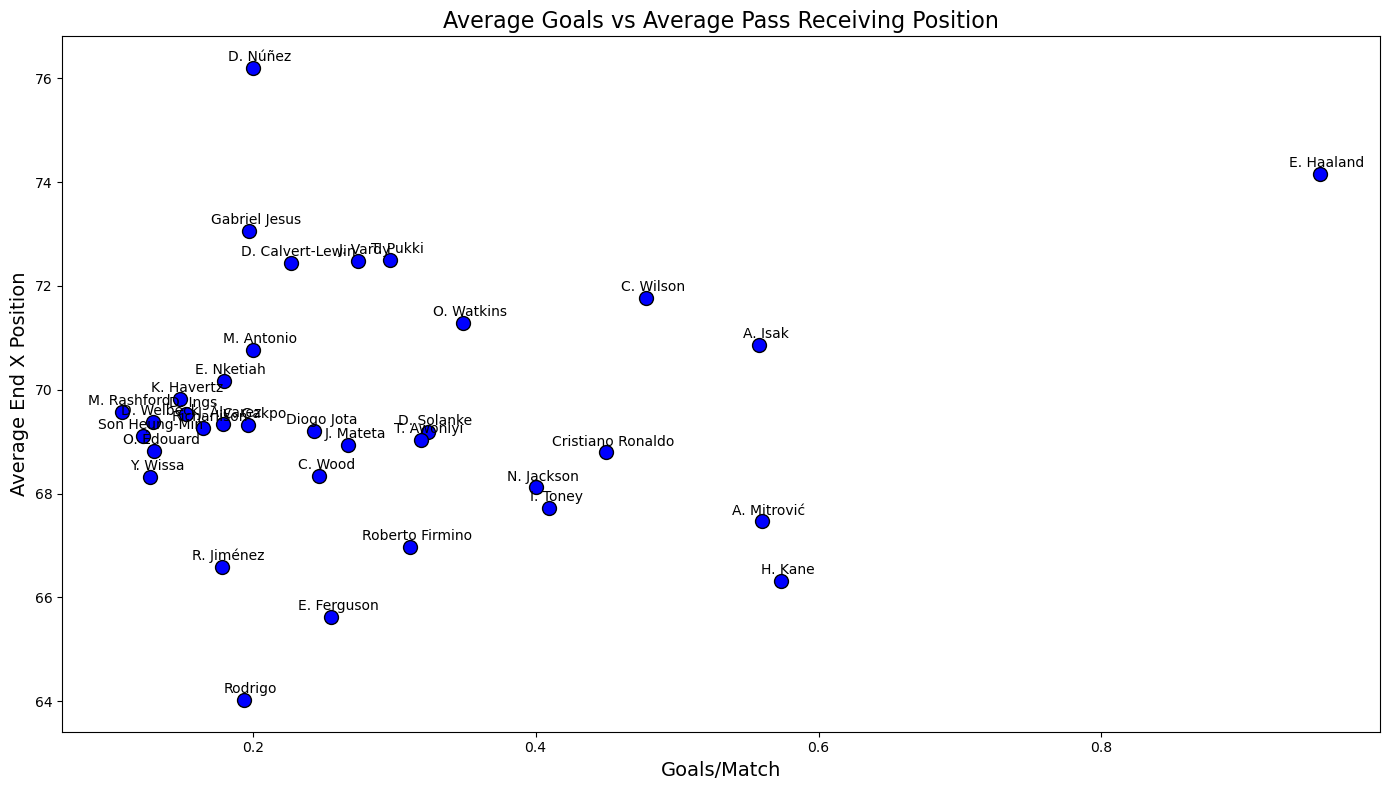

In [80]:
plt.figure(figsize=(14, 8))

# Create the scatter plot
plt.scatter(goals_df['g/match'], goals_df['average_end_x'], color='blue', edgecolors='black', s=100)

# Annotate each point with the player's name
for i, row in goals_df.iterrows():
    plt.annotate(
        row['name'], 
        (row['g/match'], row['average_end_x']), 
        textcoords="offset points", 
        xytext=(5, 5), 
        ha='center', 
        fontsize=10
    )

# Add titles and labels
plt.title('Average Goals vs Average Pass Receiving Position', fontsize=16)
plt.xlabel('Goals/Match', fontsize=14)
plt.ylabel('Average End X Position', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()


**Hipoteza se ni potdrila, saj ni občutne korelacije med dvema spremenljivkama**

# KONEC - Neuspešna oz. neuporabjena koda

## Daj podatek pass_high v gručenje

In [22]:
df_smaller_2 = df_done_copy.sample(frac=0.50, random_state=123)

# Optionally, reset the index if needed
df_smaller_2.reset_index(drop=True, inplace=True)

print(f"Original size: {len(df_done_copy)}, Reduced size: {len(df_smaller_2)}")

Original size: 89765, Reduced size: 44882


In [23]:
df_smaller_2.head(3)

start_x  start_y  end_x  end_y  pass_length  successful  pass_high  \
0    69.30     3.40  96.60   8.16    27.711867        True      False   
1    17.85    61.20  72.45  63.24    54.638097        True      False   
2    67.20    19.04  87.15   7.48    23.057235        True      False   

      angle  
0  0.172624  
1  0.037345  
2 -0.525171

In [24]:
# Convert pass_high to integers (True becomes 1, False becomes 0)
df_smaller_2["pass_high"] = df_smaller["pass_high"].astype(int)
df_smaller_2.head()

start_x  start_y  end_x  end_y  pass_length  successful  pass_high  \
0    69.30     3.40  96.60   8.16    27.711867        True          0   
1    17.85    61.20  72.45  63.24    54.638097        True          0   
2    67.20    19.04  87.15   7.48    23.057235        True          0   
3    13.65    59.16  70.35  54.40    56.899452        True          0   
4    68.25    33.32  76.65  21.76    14.289633        True          0   

      angle  
0  0.172624  
1  0.037345  
2 -0.525171  
3 -0.083754  
4 -0.942412

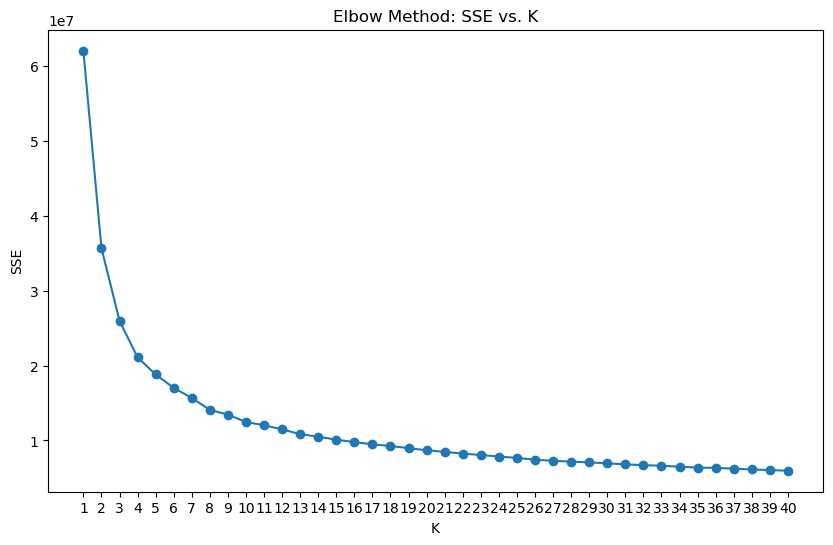

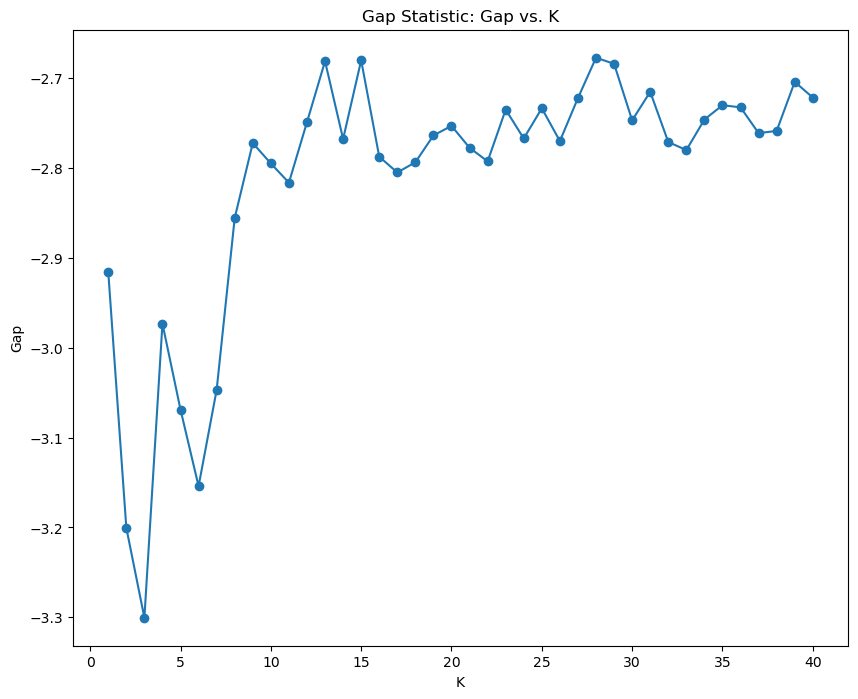

In [27]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np
import matplotlib.pyplot as plt

# Set the maximum number of clusters
k_max = 40

# Use np.linspace for a larger range
K = np.linspace(1, k_max, k_max)

# Data preparation
X = df_smaller_2[["start_x", "start_y", "end_x", "end_y", "angle", "pass_length", "pass_high"]].values

# Elbow method to determine SSE
elbow = {"sse": [], "k": [], "sil": []}
for k in K:
    cluster = KMeans(n_clusters=int(k), random_state=2147)
    labels = cluster.fit_predict(X)
    elbow["sse"].append(cluster.inertia_)
    elbow["k"].append(k)

# Create a larger plot for SSE vs. K
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.scatter(elbow["k"], elbow["sse"])
plt.plot(elbow["k"], elbow["sse"])
plt.xticks(np.linspace(1, k_max, k_max))
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method: SSE vs. K")
plt.show()

# Gap Statistic Calculation

from sklearn.metrics import pairwise_distances

def compute_inertia(a, X, centers):
    _, distances = pairwise_distances_argmin_min(centers, X)
    return np.mean(distances)

def compute_gap(clustering, data, k_max, n_references=5):
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max + 1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            clustering.fit(reference)
            centers = clustering.cluster_centers_
            local_inertia.append(compute_inertia(clustering.labels_, reference, centers))
        reference_inertia.append(np.mean(local_inertia))

    ondata_inertia = []
    for k in range(1, k_max + 1):
        clustering.n_clusters = k
        clustering.fit(data)
        centers = clustering.cluster_centers_
        ondata_inertia.append(compute_inertia(clustering.labels_, data, centers))

    gap = np.log(reference_inertia) - np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

# Compute the Gap statistic for a larger k_max
gap, reference_inertia, ondata_inertia = compute_gap(MiniBatchKMeans(random_state=2147), X, k_max)

# Create a larger plot for Gap Statistic
plt.figure(figsize=(10, 8))  # Adjust size as needed
plt.plot(range(1, k_max + 1), gap, '-o')
plt.ylabel('Gap')
plt.xlabel('K')
plt.title("Gap Statistic: Gap vs. K")
plt.show()


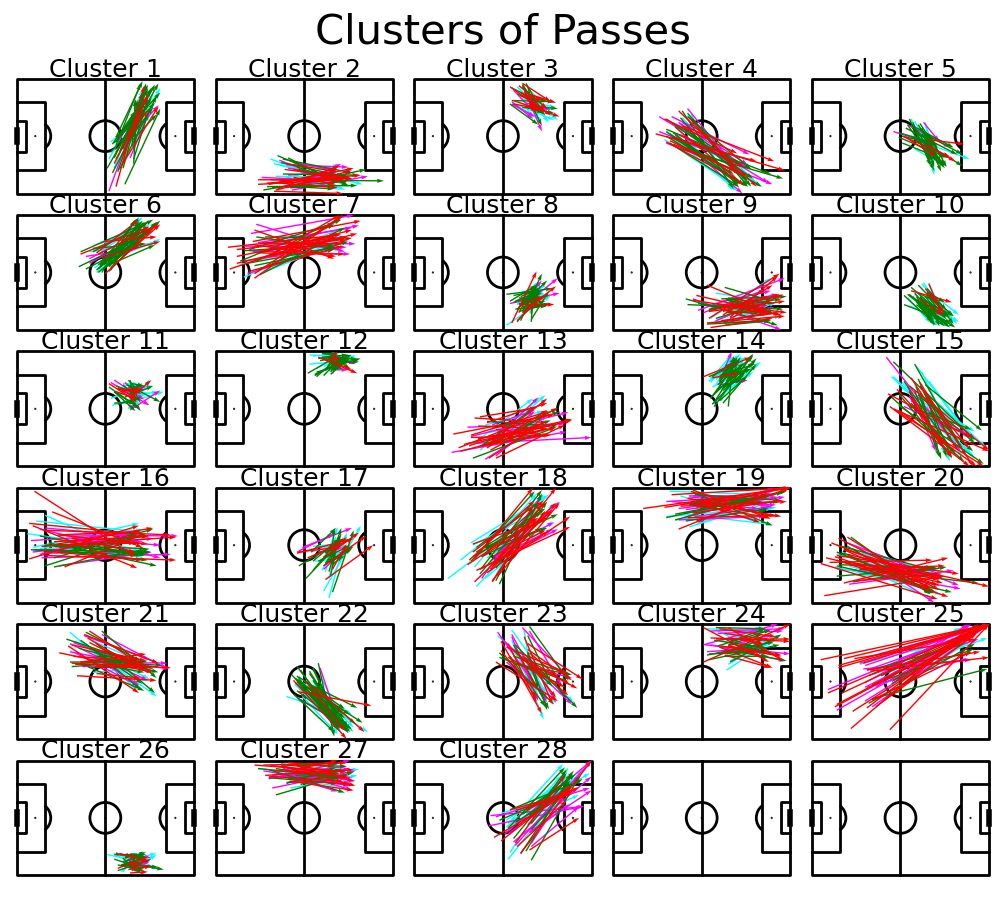

In [28]:
from sklearn.cluster import KMeans
# Perform clustering
k = 28  # Number of clusters determined by Gap Statistic
cluster = KMeans(n_clusters=k, random_state=2147)
labels = cluster.fit_predict(df_smaller_2[["start_x", "start_y", "end_x", "end_y", "angle", "pass_high"]].values)

# Add cluster labels to the dataframe
df_smaller_2["label"] = labels

# Set up the pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=5, nrows=6, grid_width=0.95, grid_height=0.9, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Maximum number of passes to display per cluster
max_passes = 50

# Plot each cluster on a separate pitch
for clust, ax in zip(range(k), axs['pitch'].flat[:k]):
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {clust + 1}",
            ha='center', va='center', fontsize=18)
    
    # Filter passes belonging to the current cluster
    clustered = df_smaller_2[df_smaller_2["label"] == clust]

    # Limit the number of passes displayed
    if len(clustered) > max_passes:
        clustered = clustered.sample(n=max_passes, random_state=2147)
    
    # Separate passes by success and pass_high (integer)
    successful_high = clustered[(clustered["successful"]) & (clustered["pass_high"] == 1)]
    unsuccessful_high = clustered[(~clustered["successful"]) & (clustered["pass_high"] == 1)]
    successful_low = clustered[(clustered["successful"]) & (clustered["pass_high"] == 0)]
    unsuccessful_low = clustered[(~clustered["successful"]) & (clustered["pass_high"] == 0)]

    # Plot successful high passes (cyan)
    pitch.arrows(
        successful_high["start_x"], successful_high["start_y"],
        successful_high["end_x"], successful_high["end_y"],
        color="cyan", ax=ax, width=1, label="Successful (High)"
    )
    
    # Plot unsuccessful high passes (magenta)
    pitch.arrows(
        unsuccessful_high["start_x"], unsuccessful_high["start_y"],
        unsuccessful_high["end_x"], unsuccessful_high["end_y"],
        color="magenta", ax=ax, width=1, label="Unsuccessful (High)"
    )
    
    # Plot successful low passes (green)
    pitch.arrows(
        successful_low["start_x"], successful_low["start_y"],
        successful_low["end_x"], successful_low["end_y"],
        color="green", ax=ax, width=1, label="Successful (Low)"
    )
    
    # Plot unsuccessful low passes (red)
    pitch.arrows(
        unsuccessful_low["start_x"], unsuccessful_low["start_y"],
        unsuccessful_low["end_x"], unsuccessful_low["end_y"],
        color="red", ax=ax, width=1, label="Unsuccessful (Low)"
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Clusters of Passes', ha='center', va='center', fontsize=30)
plt.show()

In [29]:
df_smaller_2.head()

start_x  start_y  end_x  end_y  pass_length  successful  pass_high  \
0    69.30     3.40  96.60   8.16    27.711867        True          0   
1    17.85    61.20  72.45  63.24    54.638097        True          0   
2    67.20    19.04  87.15   7.48    23.057235        True          0   
3    13.65    59.16  70.35  54.40    56.899452        True          0   
4    68.25    33.32  76.65  21.76    14.289633        True          0   

      angle  label  
0  0.172624      8  
1  0.037345      6  
2 -0.525171      9  
3 -0.083754      6  
4 -0.942412      4

In [30]:
df_smaller_2.to_csv("data/clustered_passes_HIGH_2.csv", index=False)

## Ugotovitev
**Uporabljal bom clustered_passes_HIGH_1**
* tukaj je gručenje potekalo brez pass_high parametra
* je pa bil pass_high uporabljen za prikaz
* to daje najlepše gruče z najbolj jasnim razlikovanjem visokih žog od nizkih
* na podlagi tega bom določil imena gruč